<h1> MOVING AVERAGE

In a moving average (MA) process, the current value depends linearly on the mean of the series, the current error term, and past error terms. The moving average model is denoted as MA(q), where q is the order.

**Table of contents**<a id='toc0_'></a>    
- [Preprocessing](#toc1_)    
  - [Import + setup](#toc1_1_)    
  - [Upload](#toc1_2_)    
  - [Make time serie stationary](#toc1_3_)    
  - [Plotting time series + ACF + PACF](#toc1_4_)    
  - [First main](#toc1_5_)    
  - [Check autocorrelation](#toc1_6_)    
- [Forecast](#toc2_)    
  - [Rolling forecast](#toc2_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Preprocessing](#toc0_)

## <a id='toc1_1_'></a>[Import + setup](#toc0_)

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore", message="Non-stationary starting moving average parameters")
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

# plot styles
colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728']

UNUSABLE = [
    "Rural population living in areas where elevation is below 5 meters (% of total population)",
    "Access to electricity, rural (% of rural population)",
    "Surface area (sq. km)",
    "Rural land area (sq. km)",
    "Land area (sq. km)",
    "Average precipitation in depth (mm per year)",
    "Agricultural irrigated land (% of total agricultural land)",
    "Rural land area where elevation is below 5 meters (% of total land area)",
    "Rural land area where elevation is below 5 meters (sq. km)"
]

## <a id='toc1_2_'></a>[Upload](#toc0_)

In [14]:
df = pd.read_excel('./italy_values_dataset.xlsx')

In [15]:
def test_stationarity(series: pd.Series) -> bool:    
    """Checks if a time serie is stationary with and ADF test.
    
    Args:
        series (pd.Series with float values): one time serie in the initial dataset.
        
    Returns:
        bool: if p-value < 0.05 returns True [series is stationary],  
                        else it returns False [series is not stationary]
    """
    result = adfuller(series.dropna())
    return result[1] < 0.05


## <a id='toc1_3_'></a>[Make time serie stationary](#toc0_)

In [16]:
def make_stationary(df_temp, max_d=4):
    """
    Makes a time series stationary by applying sequential differentiations (d=1, d=2...) up to max_d.

    Args:
        series (pd.Series): original time series.
        max_d (int, optional): maximum number of sequential differentiations to try. Default is 4.

    Returns:
        tuple: (stationary_series, d <order of differentiation used>). If it fails, it returns (None, -1).
    """
    
    if test_stationarity(df_temp['Value']): 
        print("Serie già stazionaria (d=0)")
        return df_temp.dropna(), 0
    print("Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:")
    current_series = df_temp['Value'].copy()
    for d in range(1, max_d + 1):
        current_series = current_series.diff()
        if len(current_series.dropna()) < 10: 
            print(f"Serie troppo corta dopo d={d}. Impossibile testare.")
            continue
        if test_stationarity(current_series.dropna()):
            print(f"Serie resa stazionaria con d={d}")
            df_temp['Diff'] = current_series
            return current_series.dropna(), d
        else:
            print(f"Serie ancora non stazionaria con d={d}")

    print(f"Impossibile rendere stazionaria la serie (testato fino a d={max_d}).")
    return None, -1

## <a id='toc1_4_'></a>[Plotting time series + ACF + PACF](#toc0_)

In [17]:
def plot_comparison_origdiff(indicator, df_temp, d):
    """ Plots original time series (non stationary) vs differentiated time series (stationary)

    Args:
        indicator (str): name of indicator for clearance
        df_temp (pd.DataFrame): DataFrame containing original and differentiated time serie
    """
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize = (10,6))
    fig.suptitle(f"{indicator}", fontsize=14, fontweight="bold")
    ax1.plot(df_temp['Year'], df_temp['Value'], 'b-', marker='.')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Value')
    ax1.set_title('Original Time Serie')
    ax1.grid(True, alpha=0.3)
    ax1.axvspan(df_temp['Year'][int(0.9*len(df_temp))], df_temp['Year'][len(df_temp)-1], color='#808080', alpha=0.2)
    
    ax2.plot(df_temp['Year'], df_temp['Diff'], 'r-', marker='.')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Value')
    ax2.set_title(f'{d}-order Differentiated Time Serie')
    ax2.grid(True, alpha=0.3)
    ax2.axvspan(df_temp['Year'][int(0.9*len(df_temp))], df_temp['Year'][len(df_temp)-1], color='#808080', alpha=0.2)

    ax1.tick_params(labelbottom=True)
    ax2.tick_params(labelbottom=True) 
    plt.setp(ax2.get_xticklabels(), visible=True) 
    plt.tight_layout()
    plt.show()

In [18]:
def plot_comparison_acfpacf(indicator, df_temp, col):
    """ Plots ACF and PACF of stationary

    Args:
        indicator (str): indicator name for clearance
        df_temp (pd.DataFrame): DataFrame containing stationary time serie
        col (str): 'Value' if d=0 hence the original time series is stationary
                    'Diff' if d!=0 and Diff contains the differentiated made stationary time series
    """
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(f"{indicator}", fontsize=14, fontweight="bold")
    plot_acf(df_temp[col].dropna(), lags=10, ax=ax[0])
    ax[0].set_title("ACF")
    ax[0].grid(True, alpha=0.3)
    plot_pacf(df_temp[col].dropna(), lags=10, ax=ax[1])
    ax[1].set_title("PACF")
    ax[1].grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()  

## <a id='toc1_5_'></a>[First main](#toc0_)
iterates on each time serie, makes stationary and plots comparison + acf + pacf


Indicator: Rural population (% of total population)
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie resa stazionaria con d=1


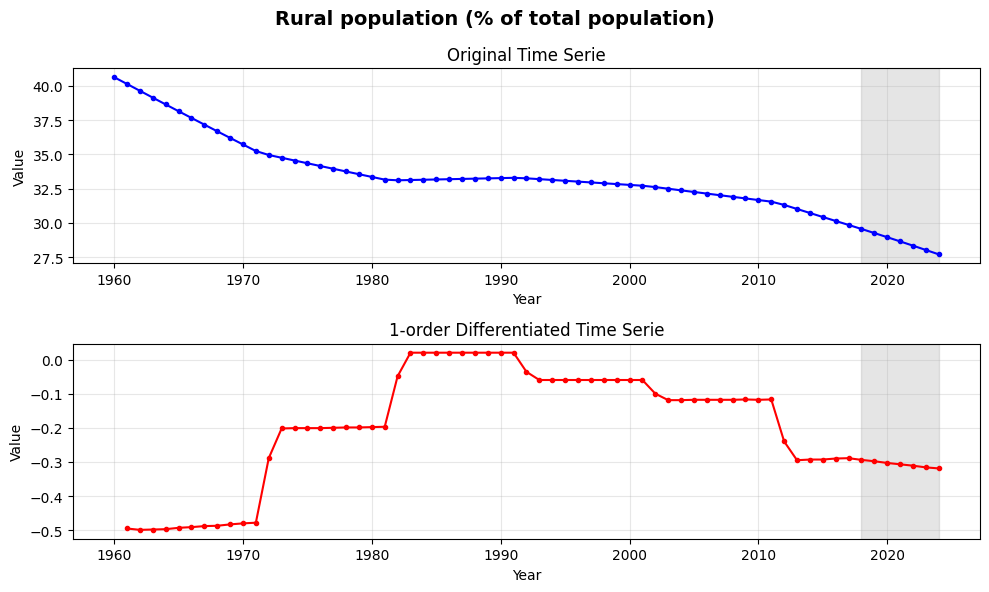

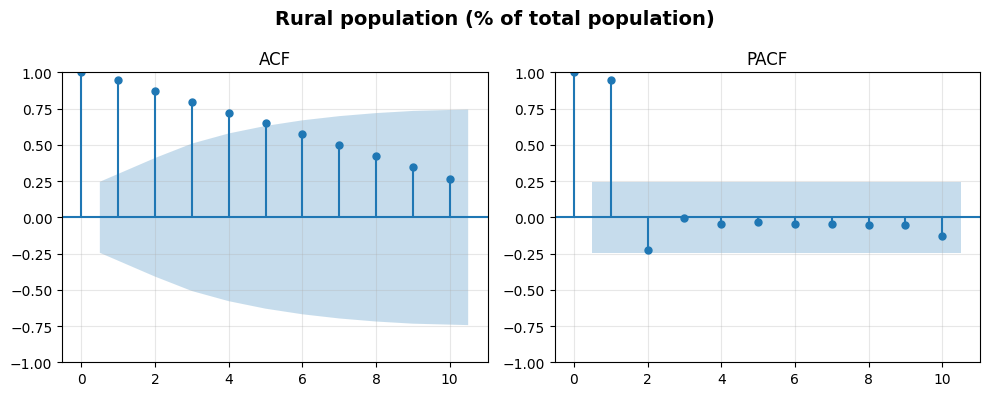


Indicator: Rural population growth (annual %)
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie resa stazionaria con d=1


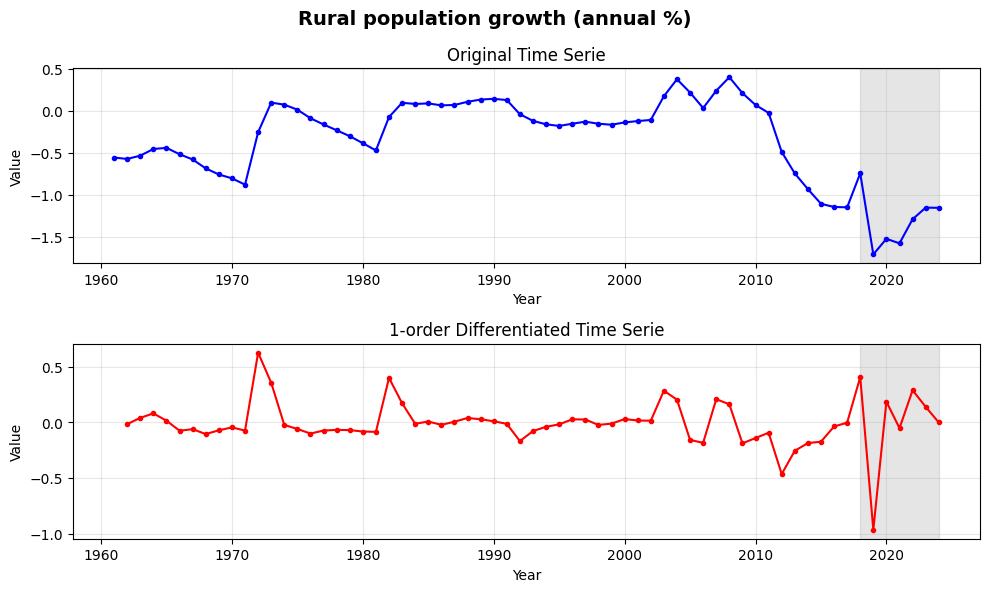

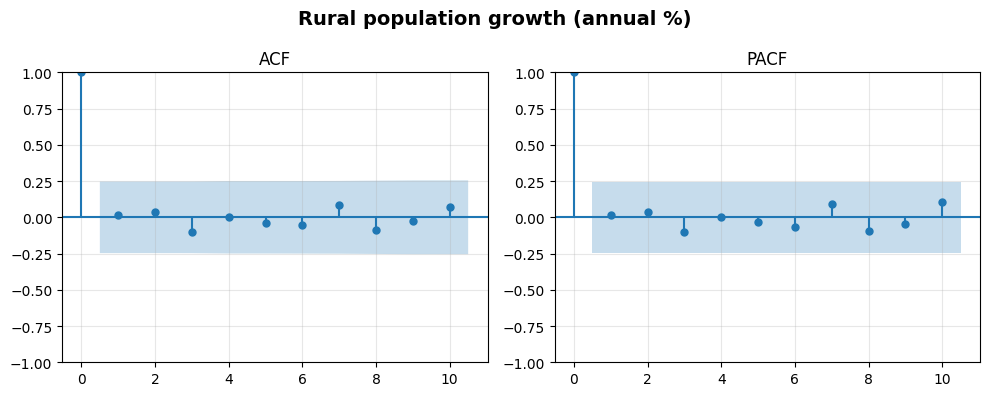


Indicator: Rural population
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie ancora non stazionaria con d=1
Serie resa stazionaria con d=2


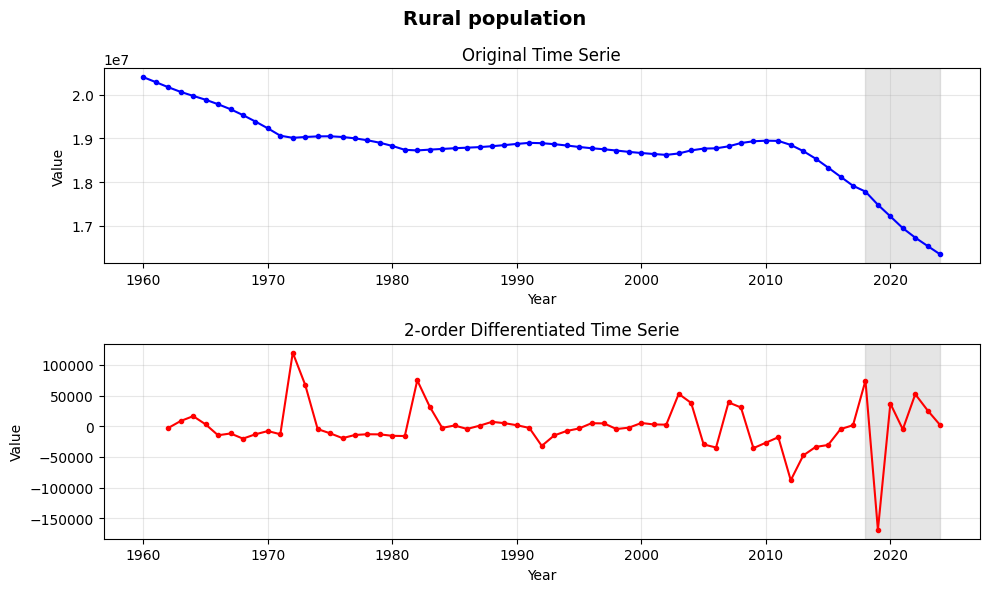

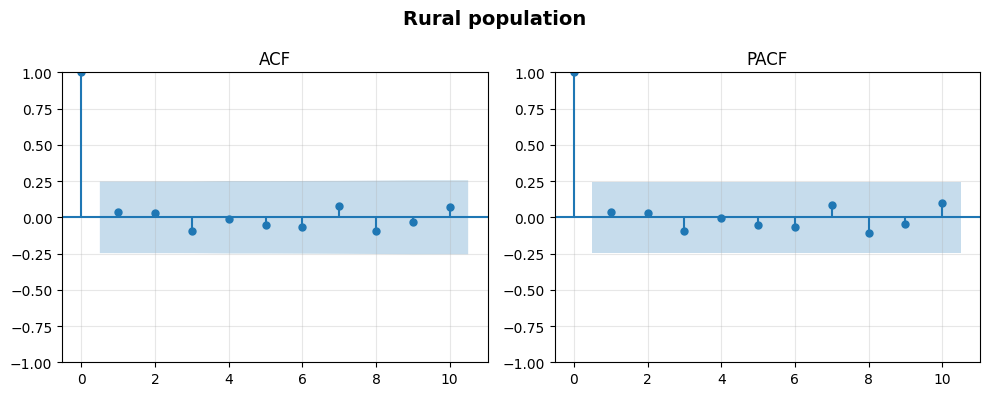


Indicator: Employment in agriculture (% of total employment)
Serie già stazionaria (d=0)
Serie stazionaria, quindi plotto acf direttamente sui valori della time serie:


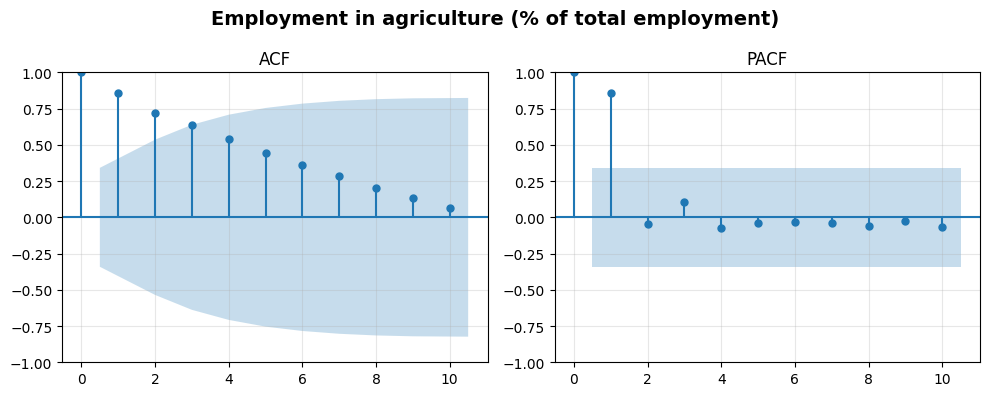


Indicator: Employment in agriculture, male (% of male employment)
Serie già stazionaria (d=0)
Serie stazionaria, quindi plotto acf direttamente sui valori della time serie:


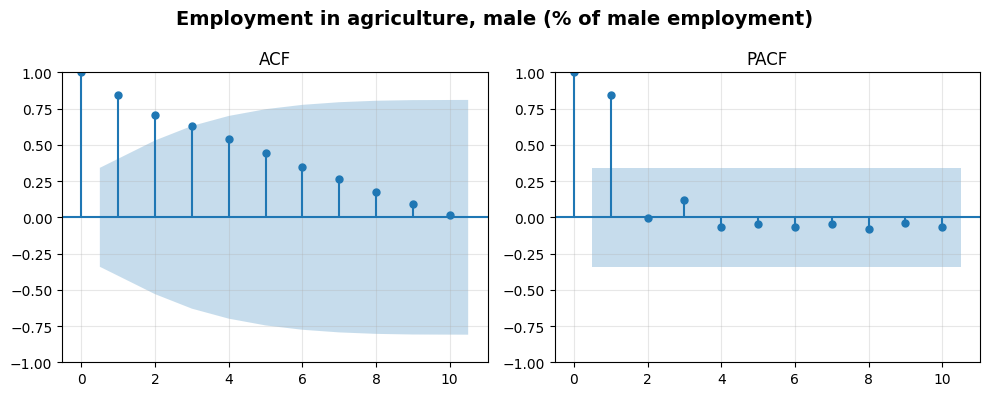


Indicator: Employment in agriculture, female (% of female employment)
Serie già stazionaria (d=0)
Serie stazionaria, quindi plotto acf direttamente sui valori della time serie:


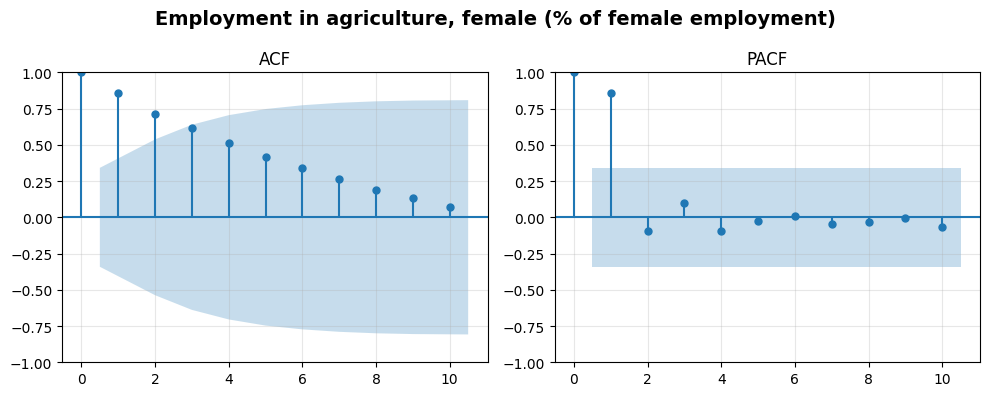


Indicator: Forest area (% of land area)
Serie già stazionaria (d=0)
Serie stazionaria, quindi plotto acf direttamente sui valori della time serie:


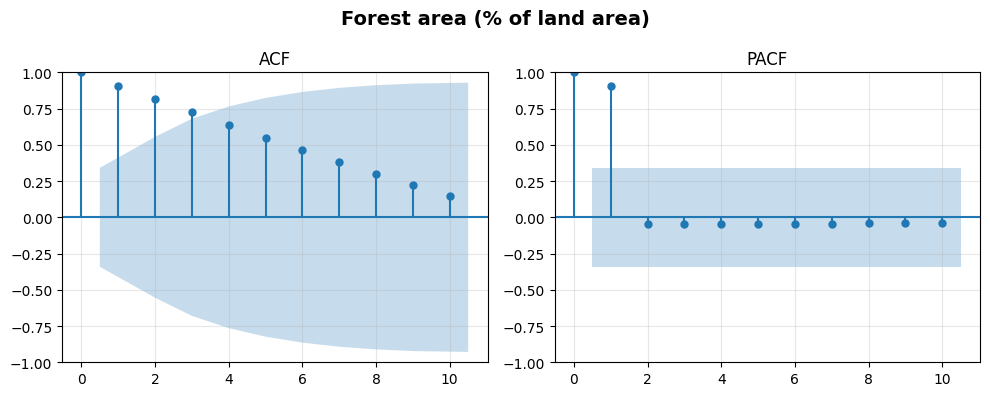


Indicator: Forest area (sq. km)
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie ancora non stazionaria con d=1
Serie resa stazionaria con d=2


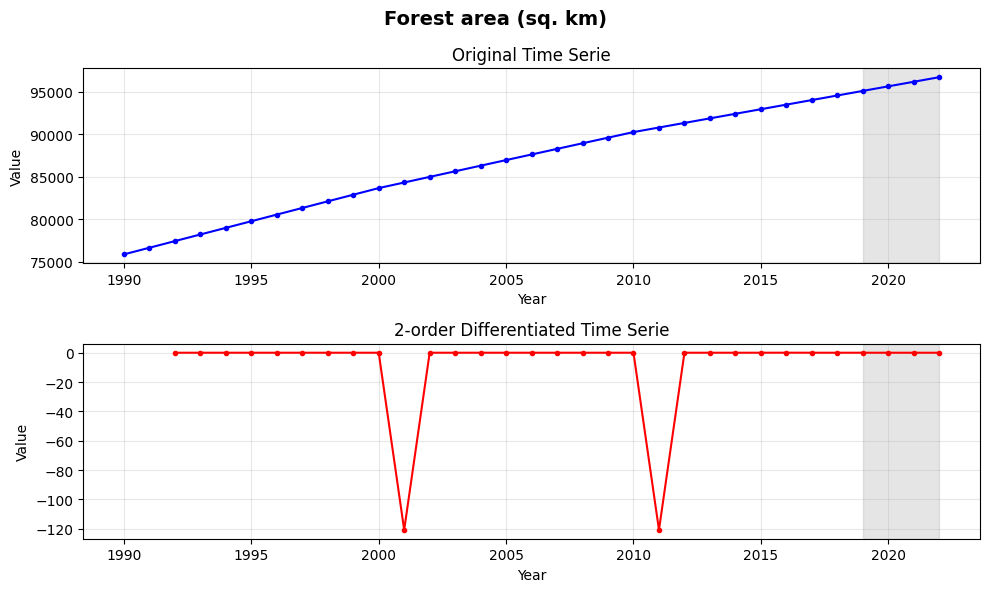

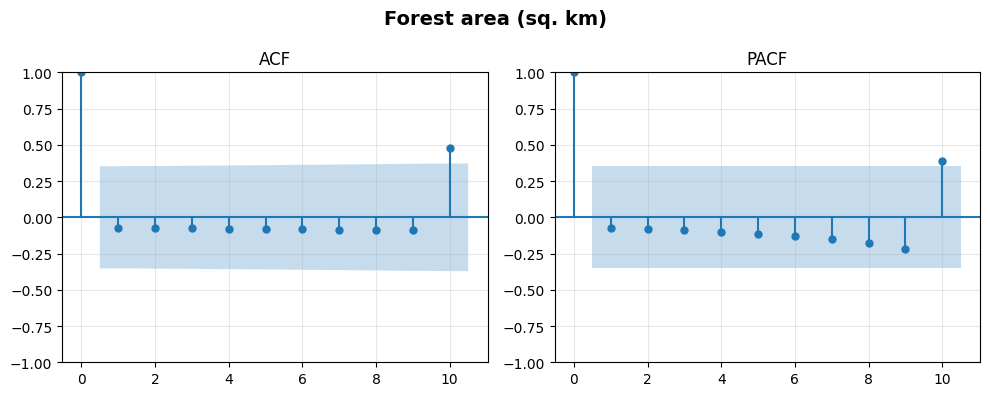


Indicator: Agricultural land (% of land area)
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie resa stazionaria con d=1


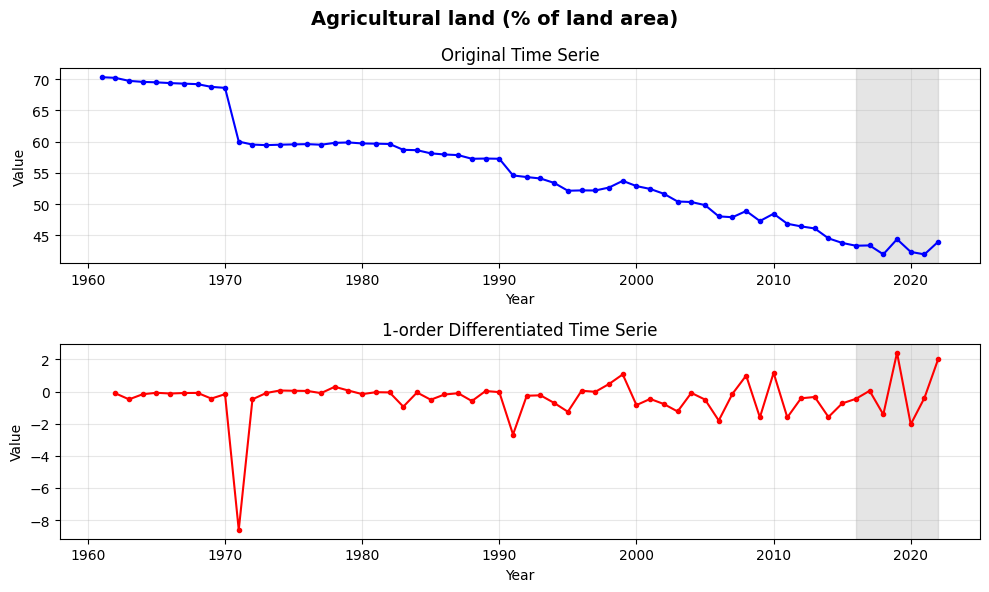

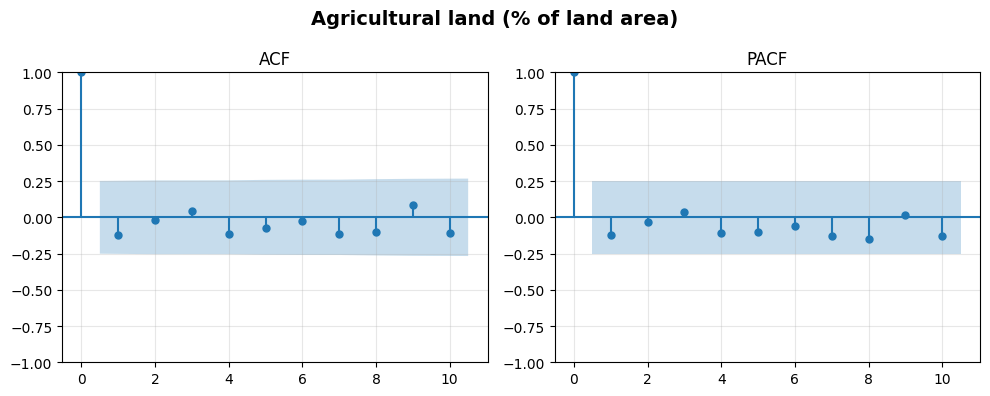


Indicator: Agricultural land (sq. km)
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie resa stazionaria con d=1


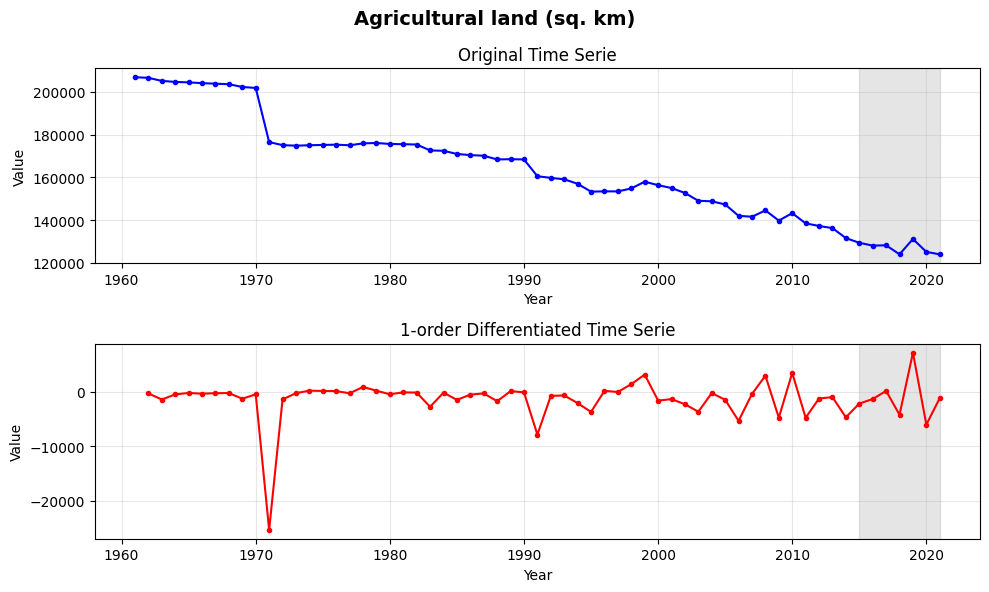

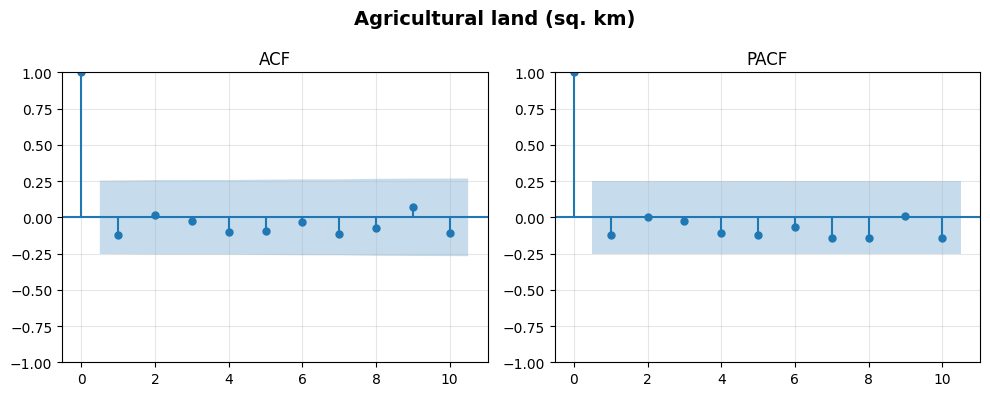


Indicator: Arable land (% of land area)
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie resa stazionaria con d=1


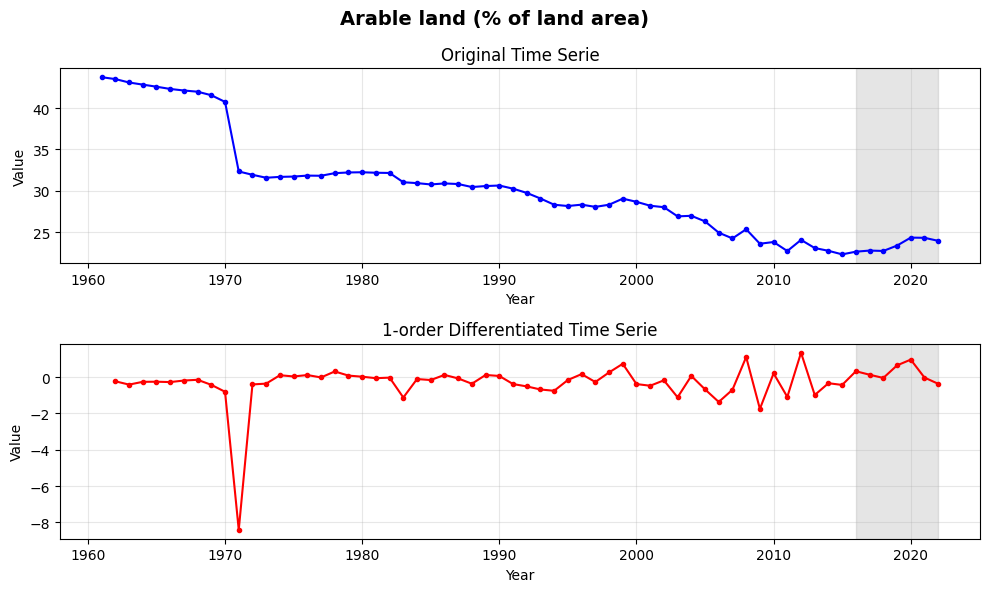

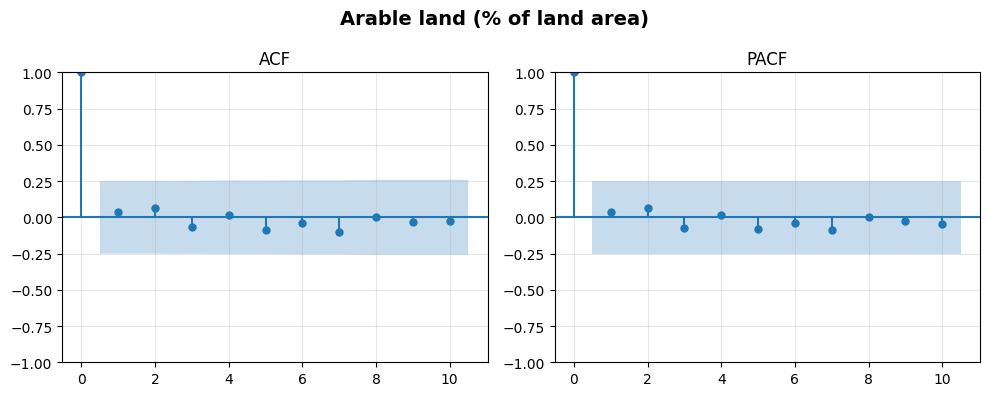


Indicator: Arable land (hectares per person)
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie resa stazionaria con d=1


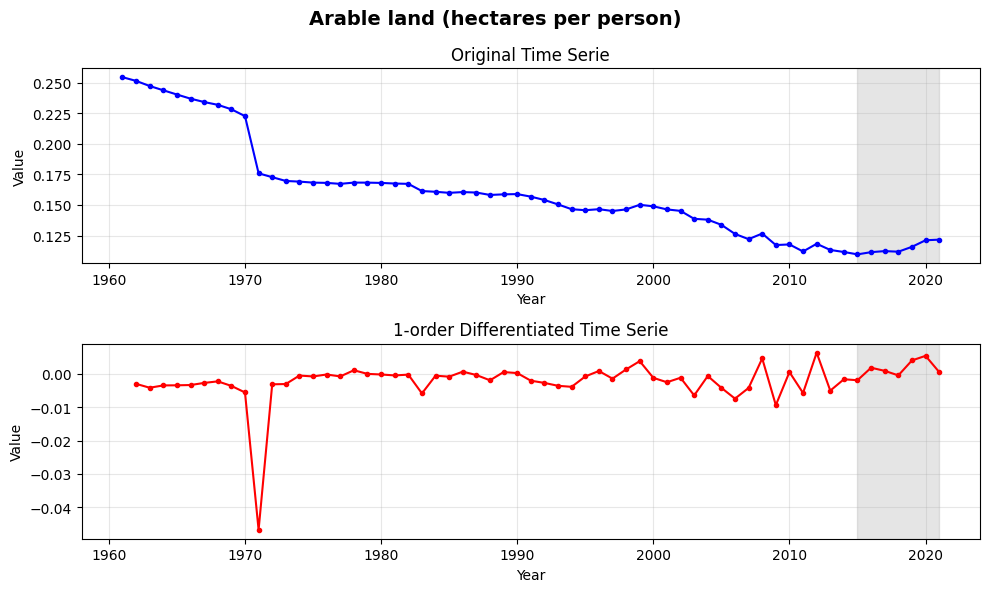

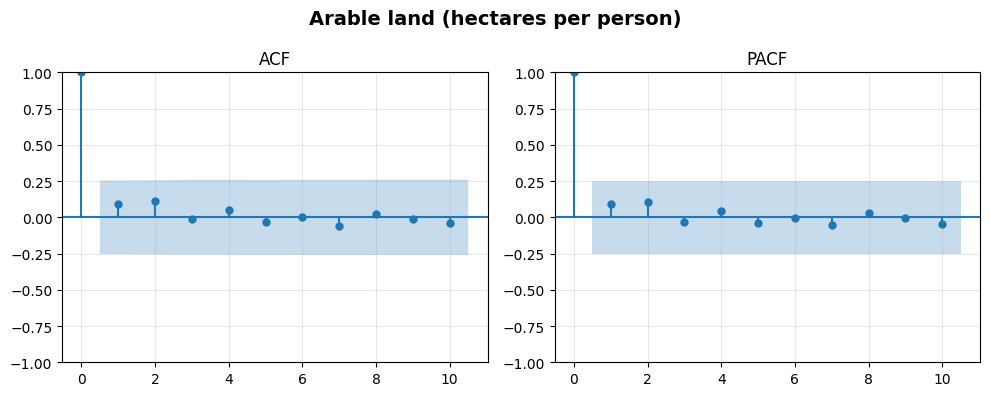


Indicator: Arable land (hectares)
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie resa stazionaria con d=1


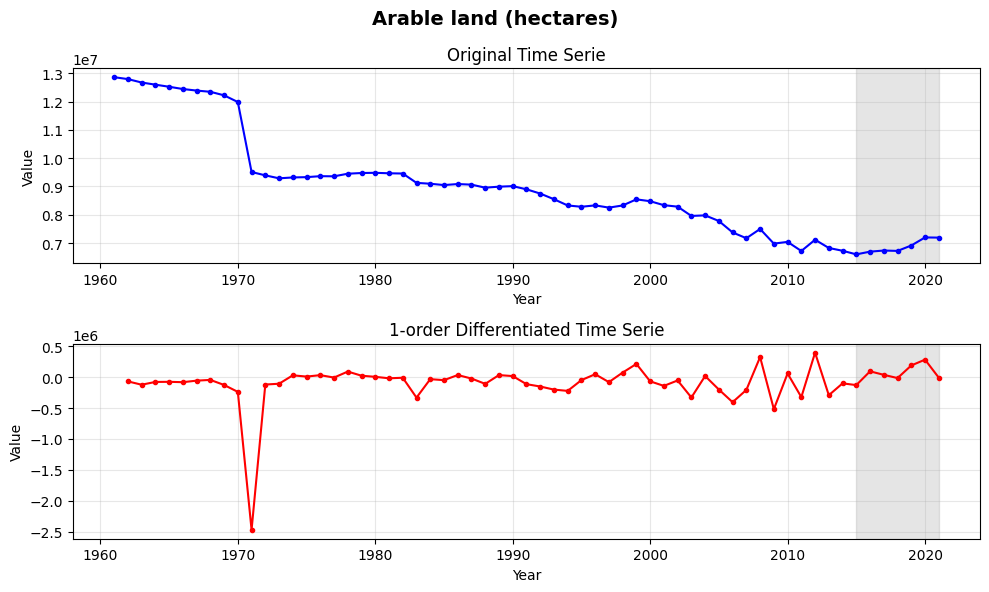

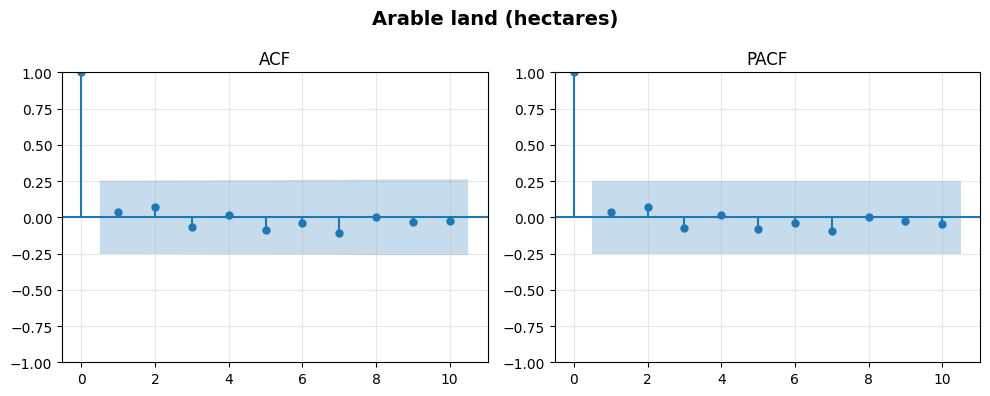


Indicator: Land under cereal production (hectares)
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie resa stazionaria con d=1


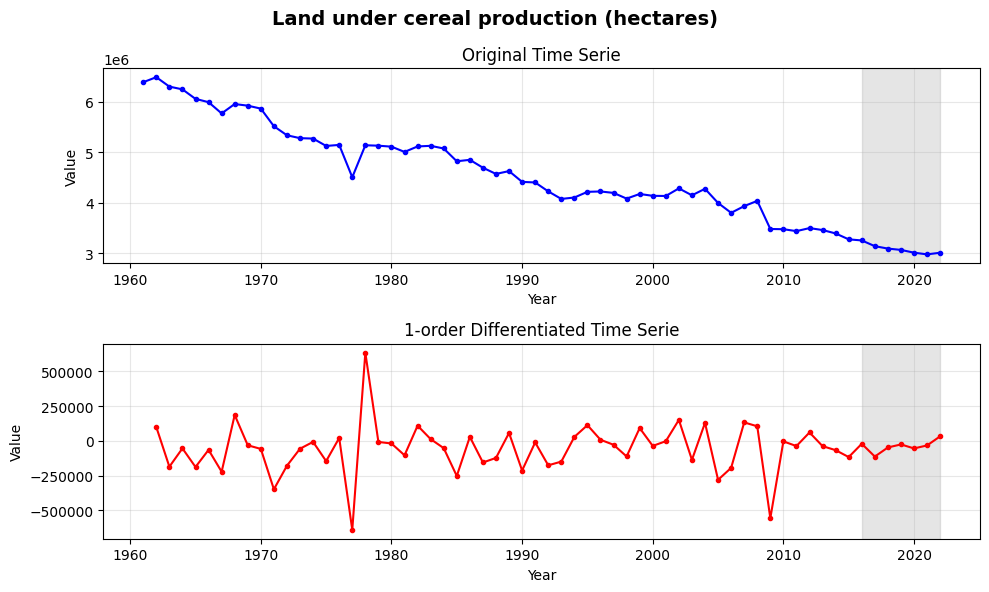

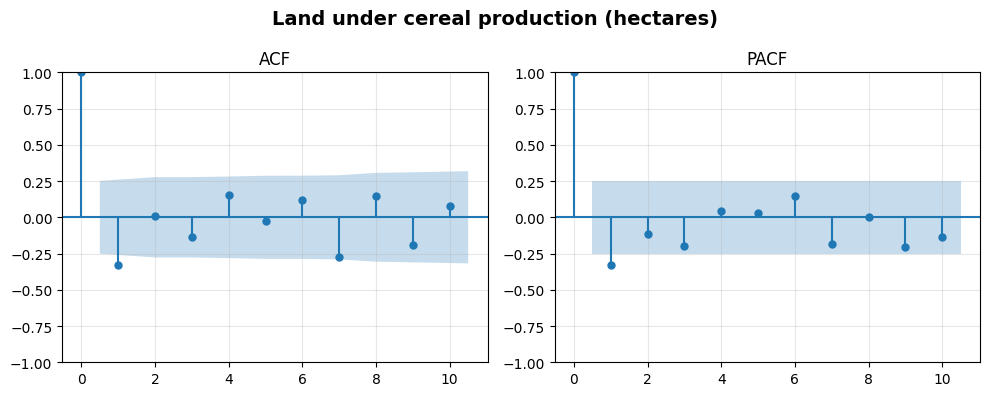


Indicator: Permanent cropland (% of land area)
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie resa stazionaria con d=1


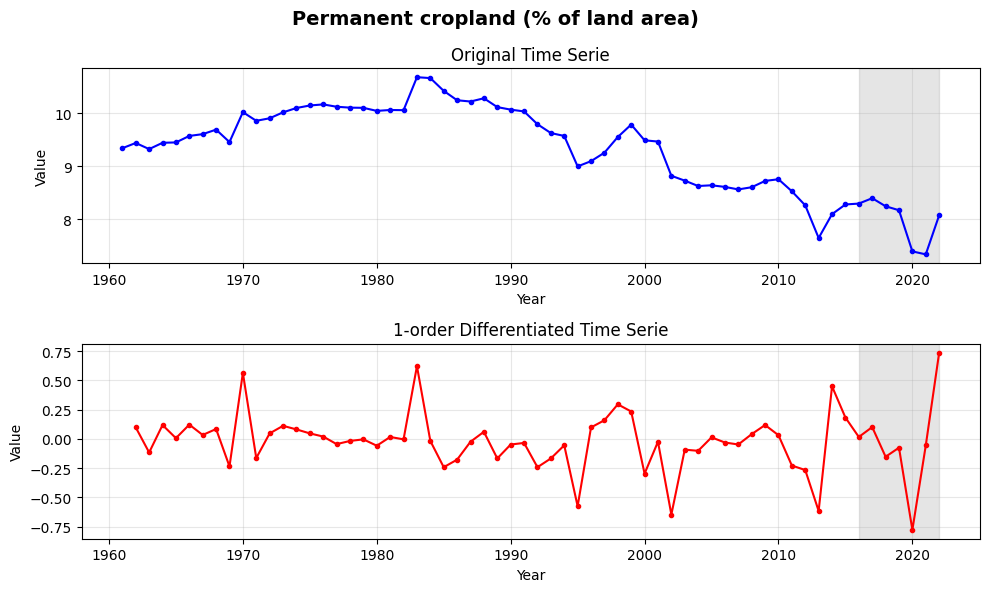

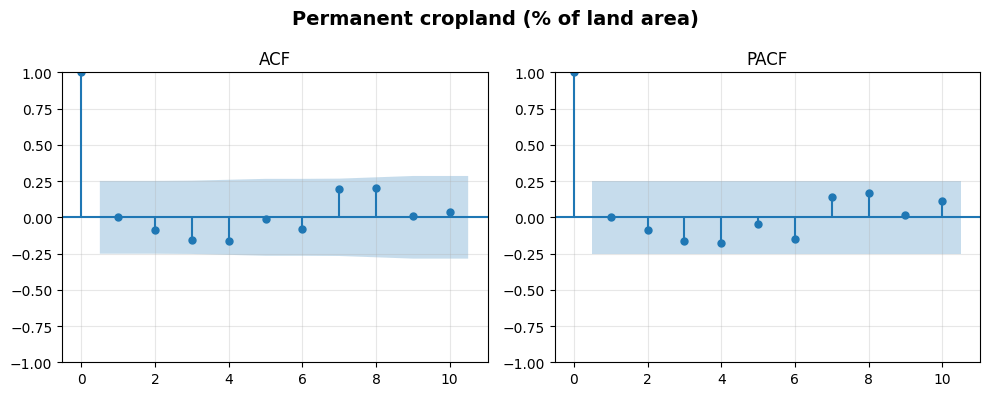


Indicator: Annual freshwater withdrawals, agriculture (% of total freshwater withdrawal)
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie resa stazionaria con d=1


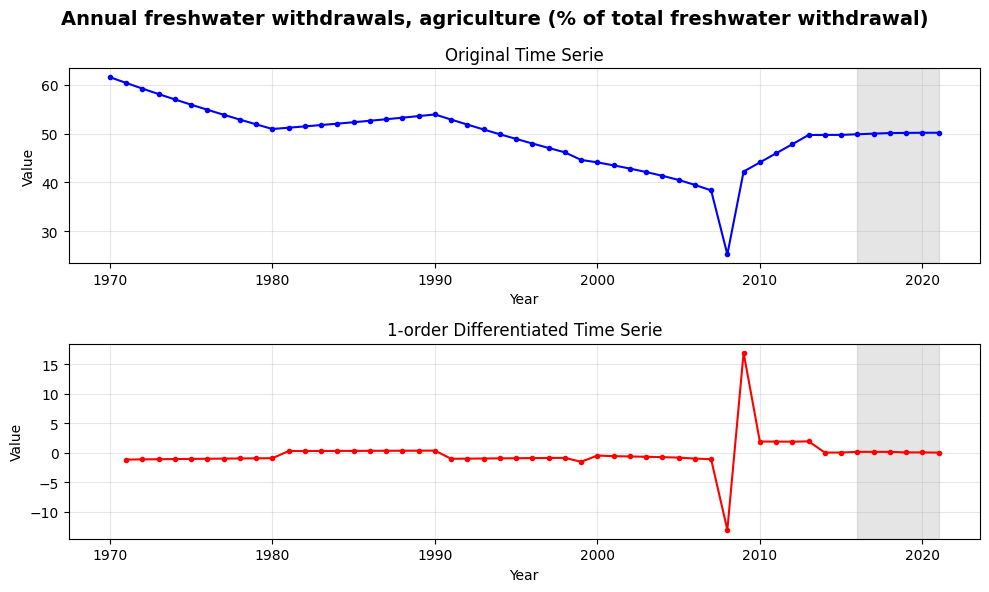

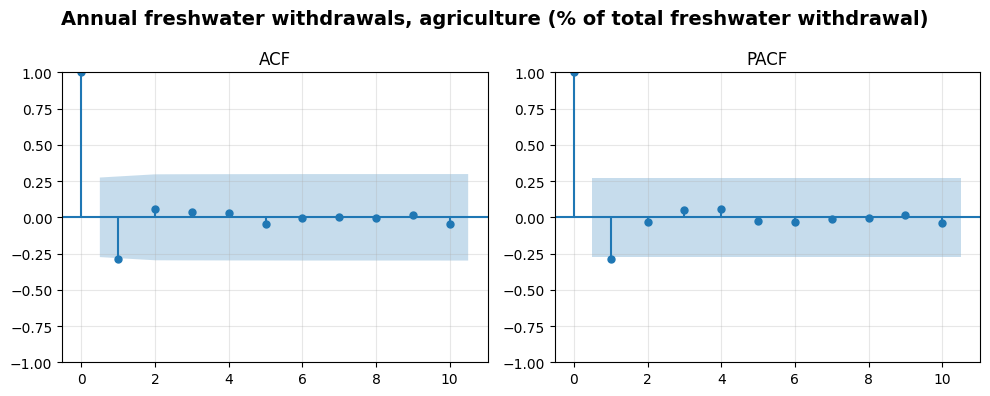


Indicator: Fertilizer consumption (kilograms per hectare of arable land)
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie ancora non stazionaria con d=1
Serie resa stazionaria con d=2


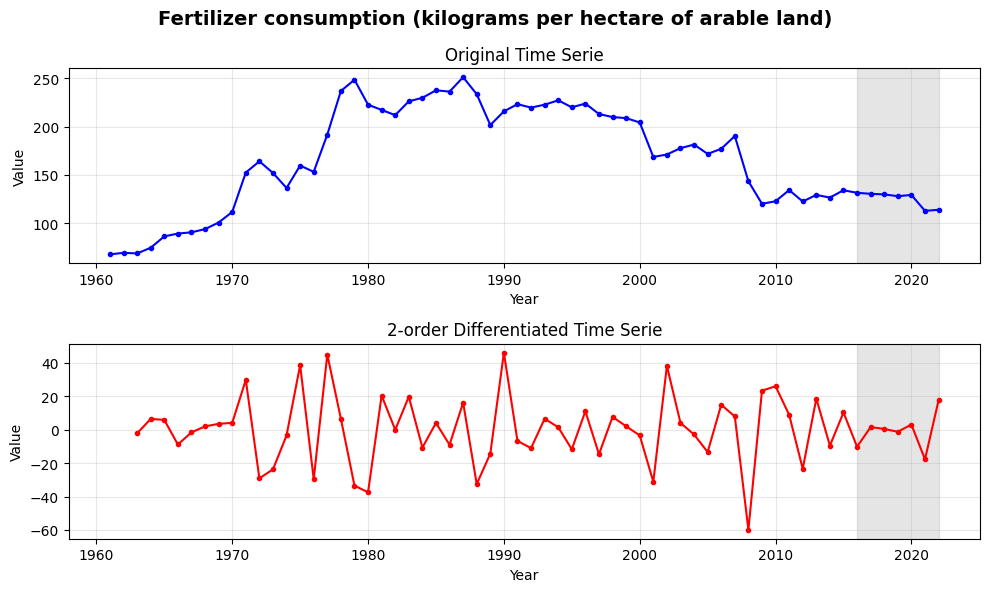

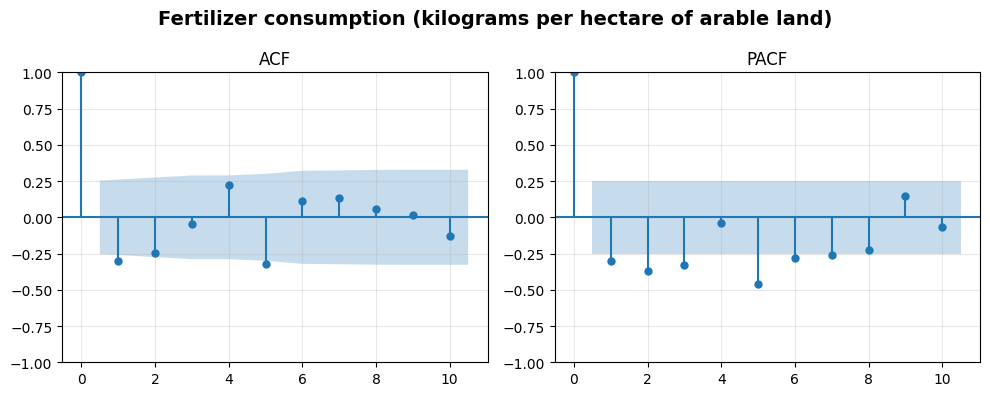


Indicator: Fertilizer consumption (% of fertilizer production)
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie resa stazionaria con d=1


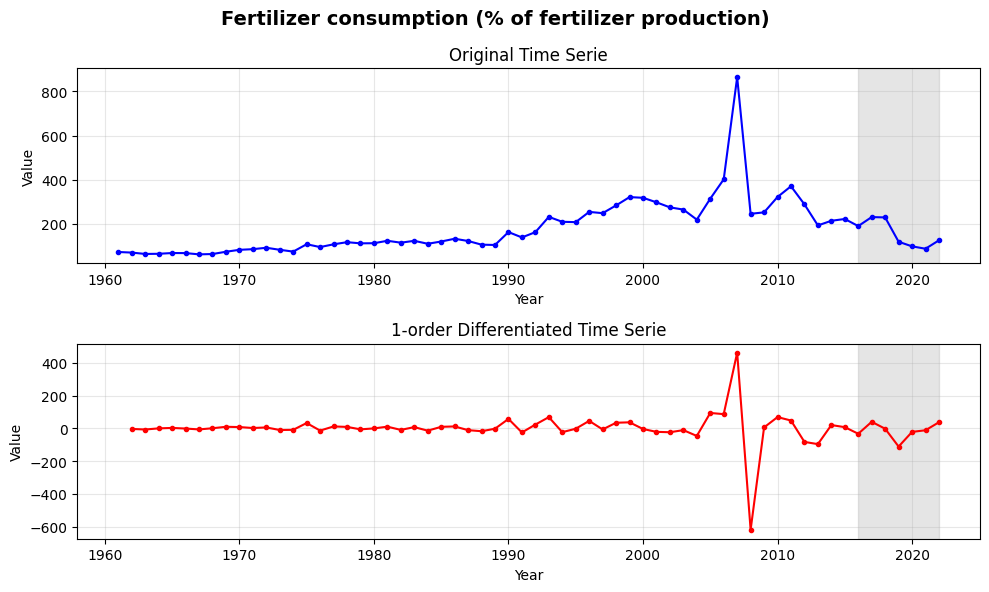

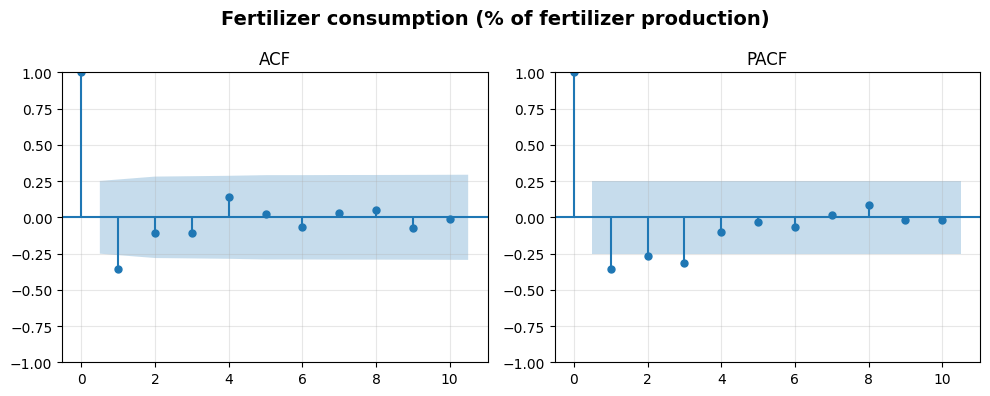


Indicator: Livestock production index (2014-2016 = 100)
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie resa stazionaria con d=1


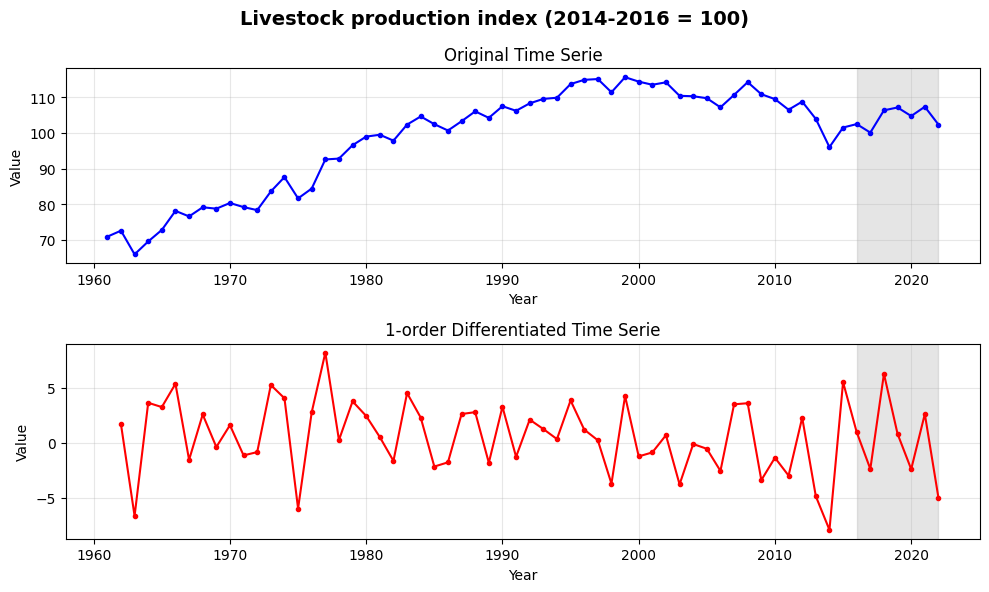

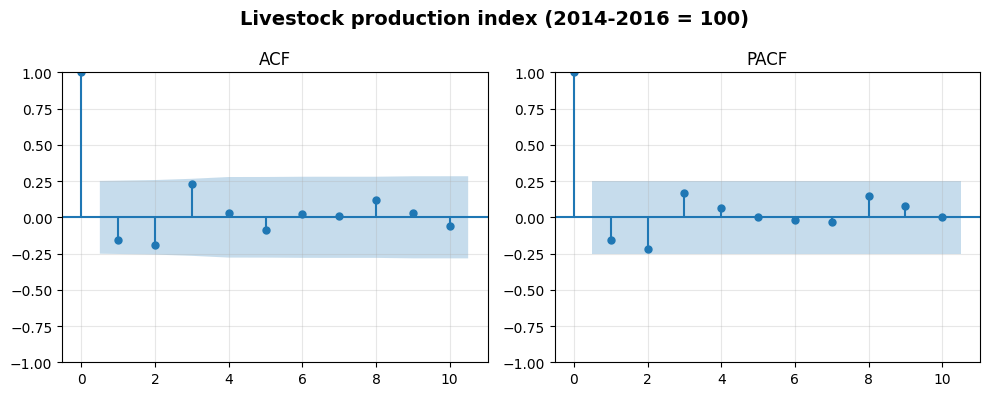


Indicator: Food production index (2014-2016 = 100)
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie resa stazionaria con d=1


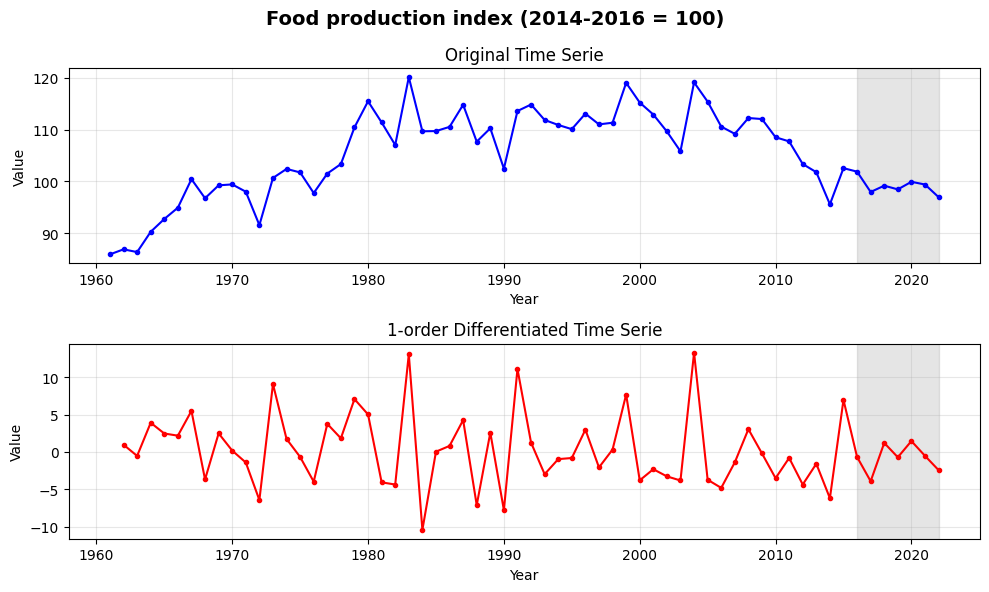

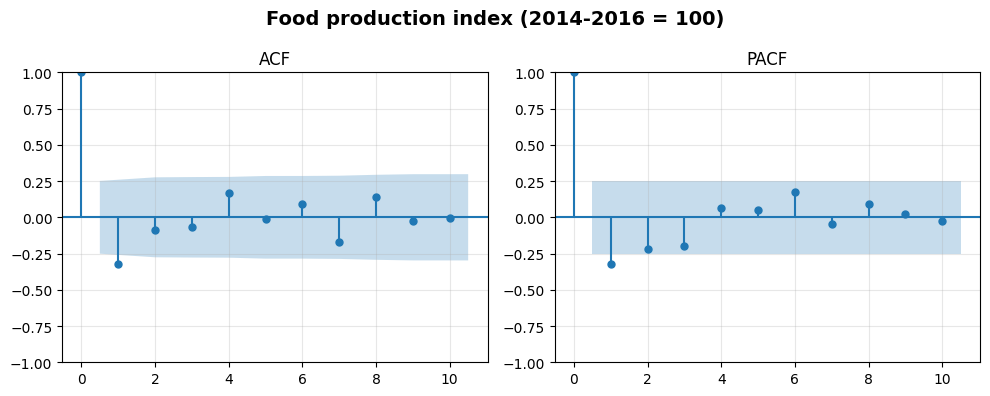


Indicator: Crop production index (2014-2016 = 100)
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie resa stazionaria con d=1


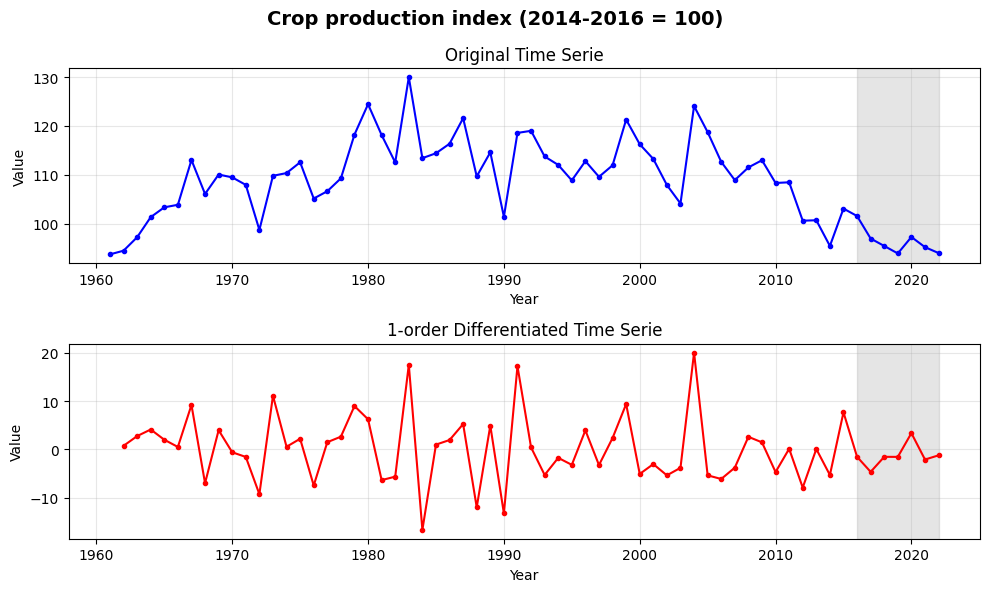

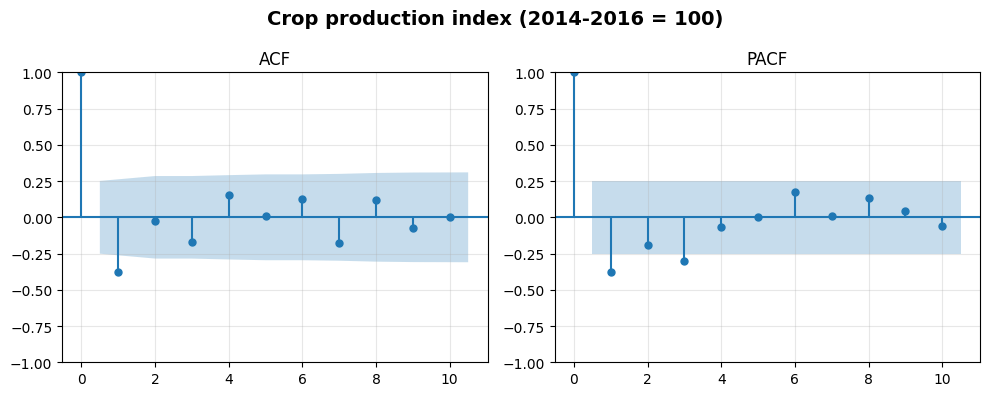


Indicator: Cereal production (metric tons)
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie resa stazionaria con d=1


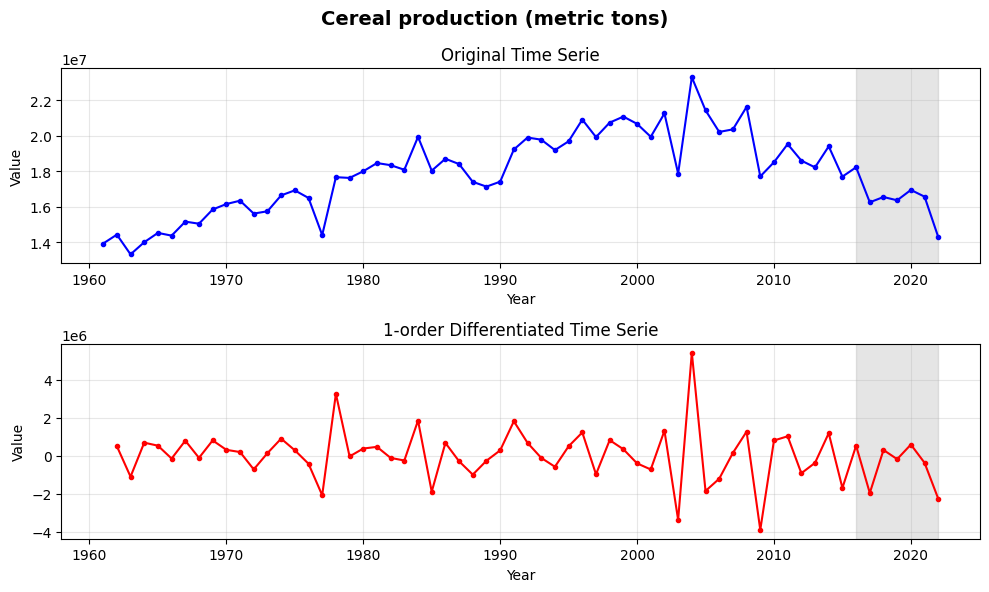

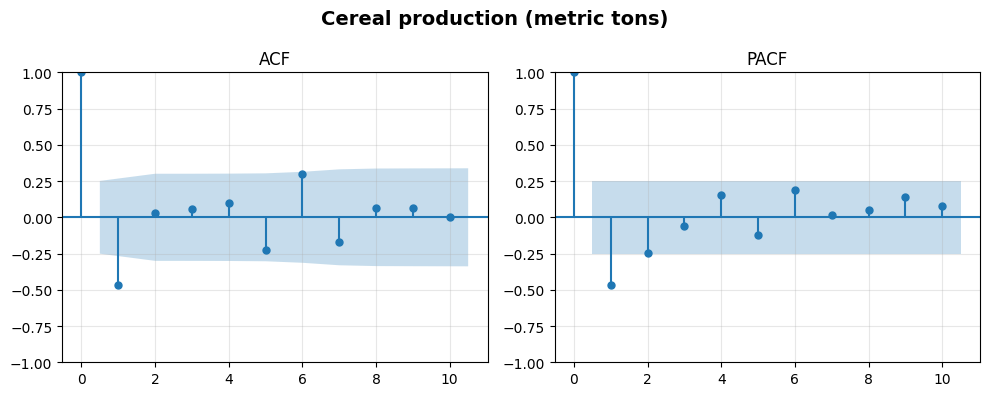


Indicator: Cereal yield (kg per hectare)
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie resa stazionaria con d=1


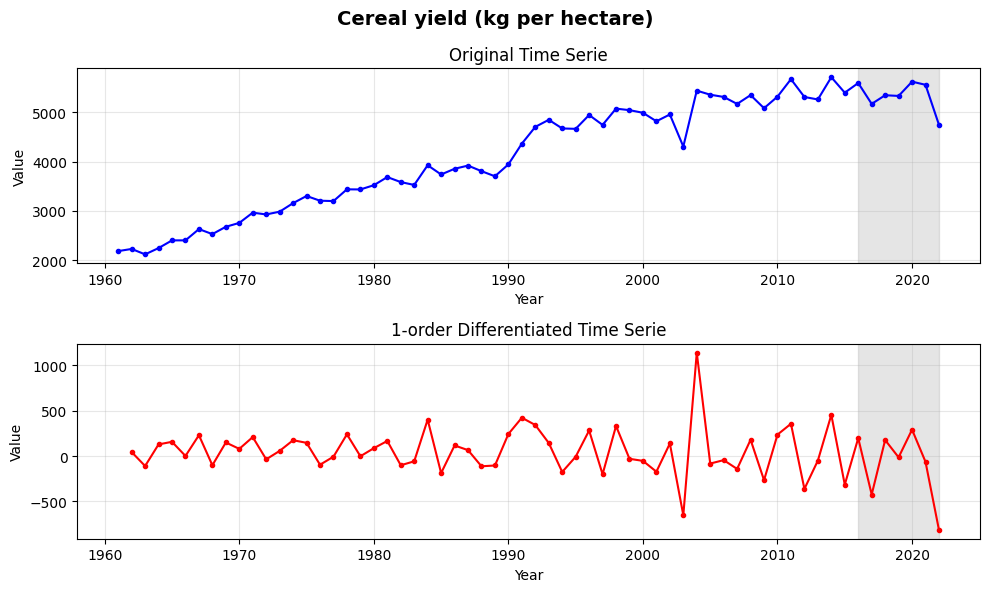

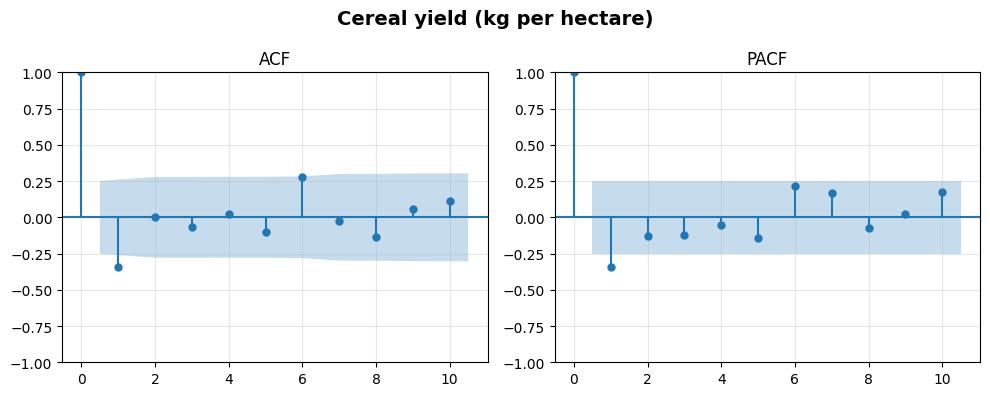


Indicator: Agriculture, forestry, and fishing, value added (% of GDP)
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie ancora non stazionaria con d=1
Serie resa stazionaria con d=2


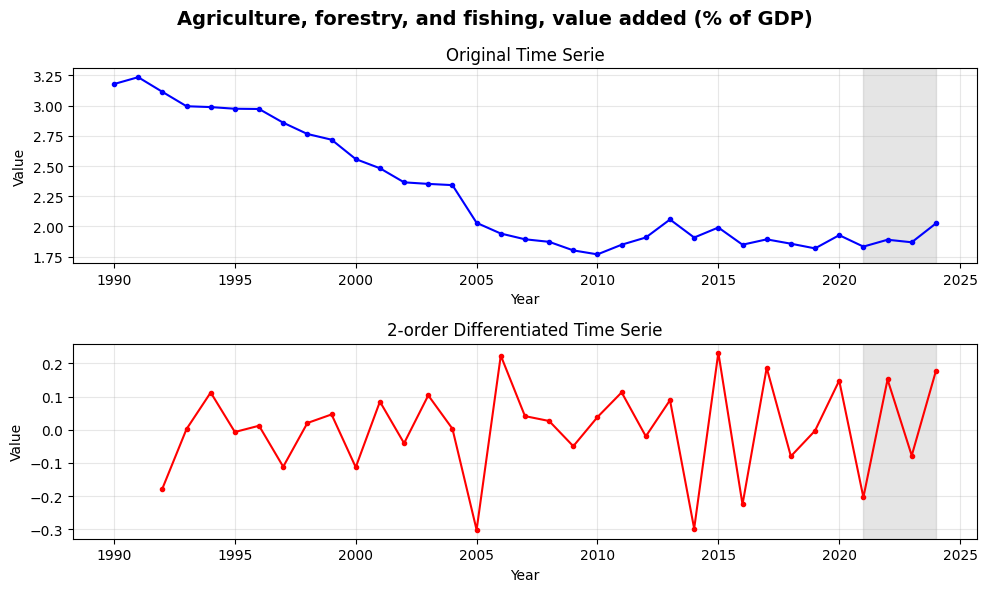

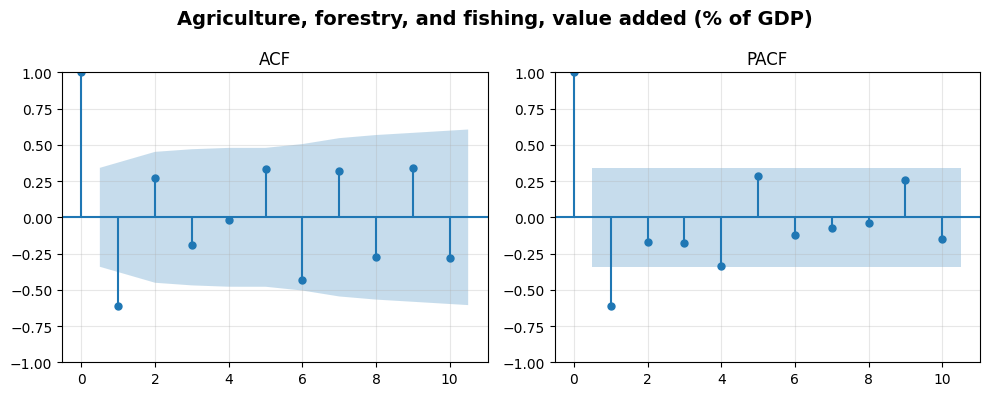


Indicator: Agriculture, forestry, and fishing, value added (current US$)
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie resa stazionaria con d=1


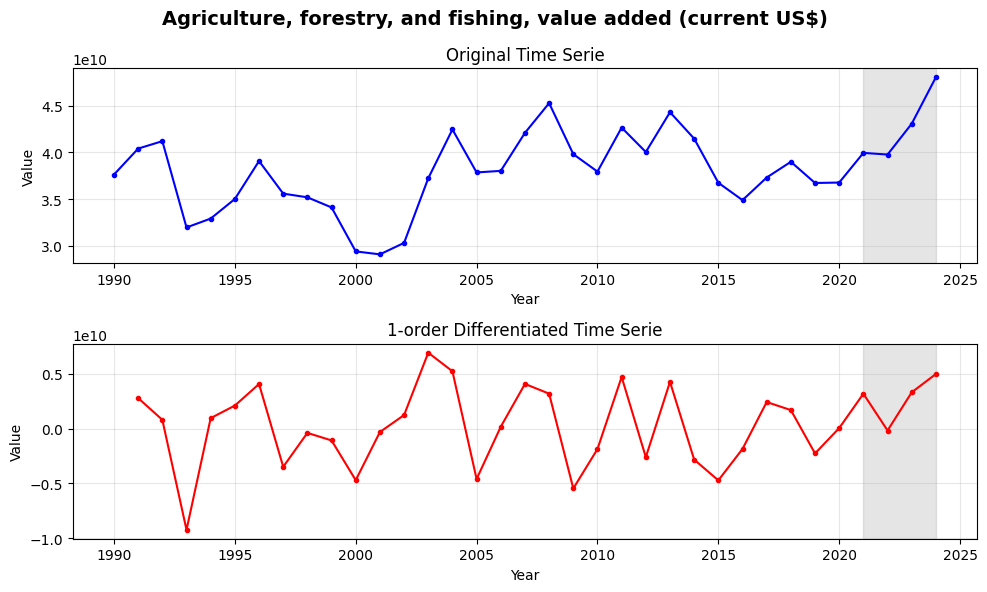

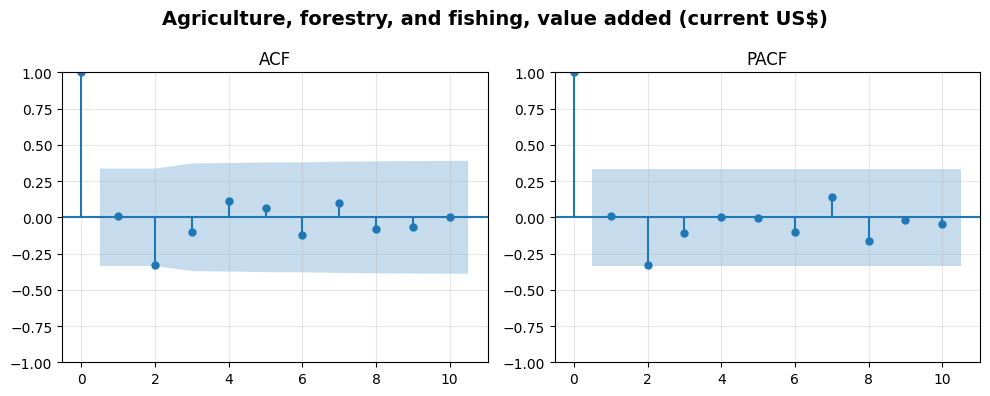


Indicator: Agricultural raw materials exports (% of merchandise exports)
Serie già stazionaria (d=0)
Serie stazionaria, quindi plotto acf direttamente sui valori della time serie:


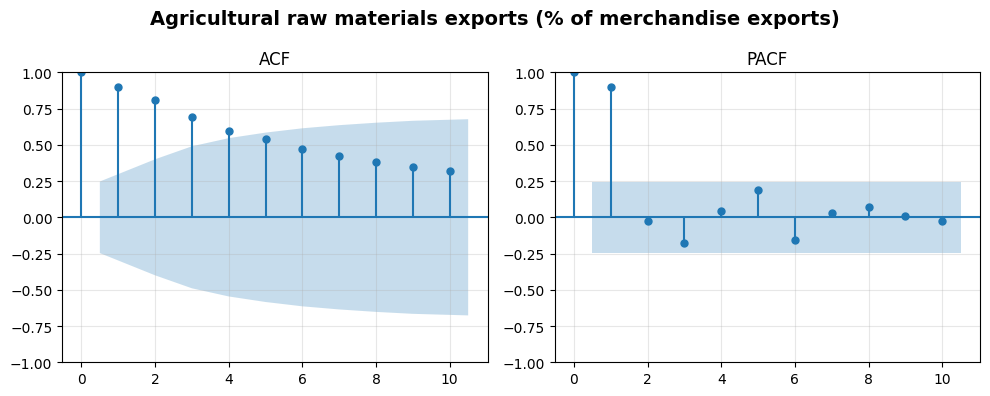


Indicator: Agricultural raw materials imports (% of merchandise imports)
Serie già stazionaria (d=0)
Serie stazionaria, quindi plotto acf direttamente sui valori della time serie:


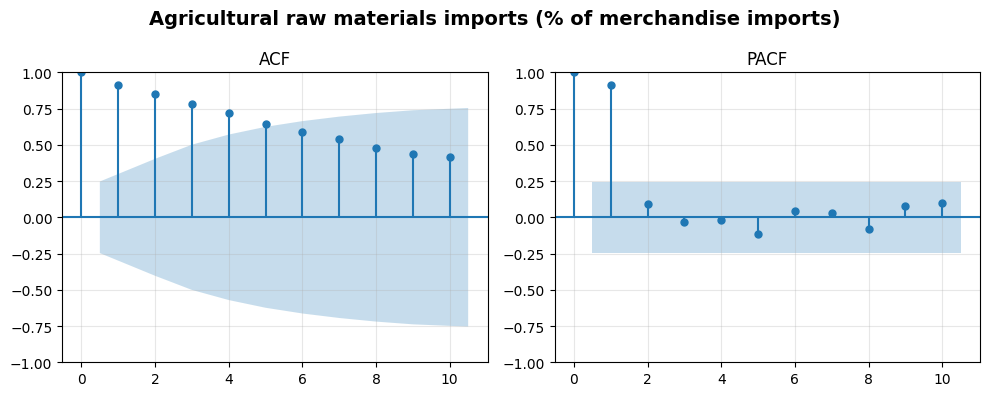

In [19]:
indicators = [i for i in df["Indicator Name"].unique() if i not in UNUSABLE]
for indicator in indicators:
    print(f"\n{'='*80}")
    print(f"Indicator: {indicator}")

    df_temp = (
        df[df["Indicator Name"] == indicator]
        .melt(id_vars=["Indicator Name"], var_name="Year", value_name="Value")
        .assign(Year=lambda d: d["Year"].astype(int))
        .dropna(subset=["Value"])
        [["Year", "Value"]]
        .reset_index(drop=True)
    )

    if df_temp.empty:
        print("Nessun dato disponibile, salto.")
        continue
    
    if len(df_temp) < 20:
        print(f"Serie di {indicator} troppo corta: {len(df_temp)} osservazioni.")
        continue

    df_stat, d = make_stationary(df_temp)
    if (d == 0) :
        print("Serie stazionaria, quindi plotto acf direttamente sui valori della time serie:")
        # PLOT ACF directly on values
        plot_comparison_acfpacf(indicator, df_temp, "Value")
    else:
        # PLOT ORIGINAL TIME SERIE VS DIFFERENTIATED TIME SERIE
        plot_comparison_origdiff(indicator, df_temp, d)
        # PLOT ACF on differenced values
        plot_comparison_acfpacf(indicator, df_temp, "Diff")

<a class="anchor" id="autocorrelation"> </a>
## <a id='toc1_6_'></a>[Check autocorrelation](#toc0_)

suitable indicators are the one that:
- in the ACF plot --> shows cut-off behaviour: significant coefficients up until lag q, then abruptly becomes non significant.
- in the PACF plot --> decrease gradually <br>
q will become the order of our MA(q) model

[Box-jenkins](https://openforecast.org/adam/BJApproach.html) <br>
For an MA(q) process, ACF will drop abruptly right after the lag q; <br>
For an MA(q) process, PACF will decline either exponentially or alternatingly (based on the specific values of parameters), starting from the lag q. <br>
However, these rules are not necessarily bi-directional and might not work in practice, e.g. if we deal with MA(q), ACF drops abruptly right after the lag q, but if ACF drops abruptly after the lag q, then this does not necessarily mean that we deal with MA(q). The former follows directly from the assumed “true” model, while the latter refers to the identification of the model on the data, and there can be different reasons for the ACF to behave in the way it does.

L'ispezione visiva mostra un taglio netto in entrambi i grafici, suggerendo un processo a memoria breve o parametri deboli. Nessuna time serie è perfettamente adatta a MA ma provo a farla andare su time serie che mostrano ACF abruptly decreasing

In [20]:
SUITABLE = ["Rural population growth (annual %)",
"Rural population",
"Agriculture, forestry, and fishing, value added (% of GDP)",
"Agriculture, forestry, and fishing, value added (current US$)",
"Annual freshwater withdrawals, agriculture (% of total freshwater withdrawal)",
"Cereal yield (kg per hectare)",
"Livestock production index (2014-2016 = 100)",
"Food production index (2014-2016 = 100)",
"Crop production index (2014-2016 = 100)",
"Cereal production (metric tons)",
"Permanent cropland (% of land area)",
"Land under cereal production (hectares)",
"Arable land (% of land area)",
"Arable land (hectares per person)",
"Arable land (hectares)",
"Agricultural land (% of land area)",
"Agricultural land (sq. km)",
"Fertilizer consumption (kilograms per hectare of arable land)",
"Fertilizer consumption (% of fertilizer production)"
]

# <a id='toc2_'></a>[Forecast](#toc0_)

## <a id='toc2_1_'></a>[Rolling forecast](#toc0_)

In [21]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon

    if method == 'mean':
        pred_mean = []
        for i in range(train_len, total_len, window):
            mean = np.mean(df["Diff"][:i])
            pred_mean.extend([mean] * window)
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        for i in range(train_len, total_len, window):
            last_value = df["Diff"][:i].iloc[-1]
            pred_last_value.extend([last_value] * window)
        return pred_last_value

    elif method == 'MA':
        pred_MA = []
        for i in range(train_len, total_len, window):
            if len(df["Diff"][:i]) < 12:
                pred_MA.extend([np.nan] * window)
                continue
            try:
                model = SARIMAX(df["Diff"][:i].values, order=(0,0,1))
                res = model.fit(disp=False)
                predictions = res.get_prediction(start=i, end=i + window - 1)
                oos_pred = predictions.predicted_mean
                pred_MA.extend(oos_pred)
            except Exception as e:
                print(f"Errore AR per finestra {i}: {e}")
                pred_MA.extend([np.nan] * window)
        return pred_MA

In [ ]:
def plot_comparison_forecasting_methods(indicator, train, test, test_results, d):
    """ Plots comparison between 'mean', 'last value' and 'MA' forecasting methods

    Args:
        indicator (str): indicator name for clearance
        train (pd.DataFrame): DataFrame containing columns "Year", "Value", "Diff"
        test (pd.DataFrame): DataFrame containing columns "Year", "Value", "Diff"
        test_results (pd.DataFrame): DataFrame containing columns "pred_mean", "pred_last_value", "pred_MA"
    """
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(13,5))
    fig.suptitle(f"Comparison on forecasting methods for {indicator} - d={d}", fontsize=14, fontweight="bold")
    ax1.plot(train['Year'], train['Diff'])
    ax1.plot(test_results['Year'], test_results['Diff'], color = colors[0], linestyle='-', label='Actual Diff')
    ax1.plot(test_results['Year'], test_results['pred_mean'], color = colors[1], linestyle=':', label='Mean')
    ax1.plot(test_results['Year'], test_results['pred_last_value'], color = colors[2], linestyle='-.', label='Last')
    ax1.plot(test_results['Year'], test_results['pred_MA'], color = colors[3], linestyle='--', label='MA(1)')
    ax1.legend(loc=2)
    ax1.set_title(f"Stationary series - d={d}")
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Difference')
    ax1.grid(True, alpha=0.3)
    start_year = int(test['Year'].iloc[0])
    end_year = int(test['Year'].iloc[-1])
    ax1.axvspan(start_year - 0.5, end_year + 0.5, color='#808080', alpha=0.2)
    
    ax2.plot(test_results['Year'], test_results['Diff'], color = colors[0], linestyle='-', label='Actual Diff', marker='o')
    ax2.plot(test_results['Year'], test_results['pred_mean'], color = colors[1], linestyle=':', label='Mean', marker='s')
    ax2.plot(test_results['Year'], test_results['pred_last_value'], color = colors[2], linestyle='-.', label='Last', marker='^')
    ax2.plot(test_results['Year'], test_results['pred_MA'], color = colors[3], linestyle='--', label='MA(1)', marker='d')
    ax2.legend(loc=2)
    ax2.set_title("Differenced test set")
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Difference')
    ax2.grid(True, alpha=0.3)
    
    ax1.tick_params(labelbottom=True)
    ax2.tick_params(labelbottom=True) 
    plt.setp(ax2.get_xticklabels(), visible=True)
    plt.tight_layout()
    plt.show()

In [ ]:
# # INVERSE TRANSFORMATION ================================================================================================
    # print("\n=== Year alignment check ===")
    # print("test_results Years:", test_results['Year'].head(5).tolist(), " ... ", test_results['Year'].tail(3).tolist())
    # print("test_original Years:", test_original['Year'].head(5).tolist(), " ... ", test_original['Year'].tail(3).tolist())
    # # prendi i primi k valori di test_results['Diff'] non-NaN per il test
    # k = min(5, len(test_results))
    # preds_diff = test_results['Diff'].values[:k]  # questi sono i diff reali (notare che in pratica potresti usare le predizioni)
    # reconstructed = invert_forecast(preds_diff, n_levels, last_obs)
    # print("\n=== quick inversion test on actual diffs (first k) ===")
    # print("preds_diff:", preds_diff)
    # print("reconstructed:", reconstructed)
    # print("actual test_original first k values:", test_original['Value'].values[:k])


    # n_levels = diff_count + 1 
    # series = train_original['Value'].copy()
    # last_obs = [series.iloc[-1]]  # livello 0
    # print(f"last obs: {last_obs}")
    # temp = series.copy()
    # for _ in range(1, n_levels):
    #     temp = temp.diff()
    #     # check che ci siano valori dopo dropna
    #     non_na = temp.dropna()
    #     if non_na.empty:
    #         raise ValueError(f"Impossibile trovare last_obs per livello {_}: serie troppo corta.")
    #     last_obs.append(non_na.iloc[-1])

    # # inverse-transform each forecast column
    # test_results['pred_mean_levels'] = invert_forecast(test_results['pred_mean'].values, n_levels, last_obs)
    # test_results['pred_last_value_levels'] = invert_forecast(test_results['pred_last_value'].values, n_levels, last_obs)
    # test_results['pred_MA_levels'] = invert_forecast(test_results['pred_MA'].values, n_levels, last_obs)
    
    # # # Allinea con i valori originali del test set
    # # # I valori originali del test set iniziano da split_idx
    # # test_actual_values = test_original['Value'].values

    # # valid_idx = ~np.isnan(test_results['pred_MA_levels'])
    # # if np.sum(valid_idx) > 0:
    # #     test_results = test_results[valid_idx]
    # #     actual_values_valid = test_actual_values[valid_idx]
        
    # #     mae_mean = mean_absolute_error(actual_values_valid, test_results['pred_mean_levels'])
    # #     mae_last = mean_absolute_error(actual_values_valid, test_results['pred_last_value_levels'])
    # #     mae_ar = mean_absolute_error(actual_values_valid, test_results['pred_MA_levels'])

    # #     mse_mean = mean_squared_error(actual_values_valid, test_results['pred_mean_levels'])
    # #     mse_last = mean_squared_error(actual_values_valid, test_results['pred_last_value_levels'])
    # #     mse_ar = mean_squared_error(actual_values_valid, test_results['pred_MA_levels'])
        
    # #     print(f"MAE livello originale -> mean: {mae_mean:.3f}, last: {mae_last:.3f}, MA(1): {mae_ar:.3f}")
    # #     print(f"MSE livello originale -> mean: {mse_mean:.3f}, last: {mse_last:.3f}, MA(1): {mse_ar:.3f}")

    # # test['pred_mean_levels'] = np.cumsum(test['pred_mean']) + last_train_value
    # # test['pred_last_value_levels'] = np.cumsum(test['pred_last_value']) + last_train_value
    # # test['pred_AR_levels'] = np.cumsum(test['pred_AR']) + last_train_value
    
    # # # mae e mse a confronto
    # # mae_mean = mean_absolute_error(test['Value'], test['pred_mean_levels'])
    # # mae_last = mean_absolute_error(test['Value'], test['pred_last_value_levels'])
    # # mae_ar = mean_absolute_error(test['Value'], test['pred_AR_levels'])

    # # mse_mean = mean_squared_error(test['Value'], test['pred_mean_levels'])
    # # mse_last = mean_squared_error(test['Value'], test['pred_last_value_levels'])
    # # mse_ar = mean_squared_error(test['Value'], test['pred_AR_levels'])
    
    # # print(f"MAE livello originale -> mean: {mae_mean:.3f}, last: {mae_last:.3f}, AR(2): {mae_ar:.3f}")
    # # print(f"MSE livello originale -> mean: {mse_mean:.3f}, last: {mse_last:.3f}, AR(2): {mse_ar:.3f}")
    
    # # PLOT COMPARISON ON FORECASTING METHODS on inverse-trasnformed time series
    # fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(13,5))
    # fig.suptitle(f"Comparison on forecasting methods for inverse-transformed {indicator}", fontsize=14, fontweight="bold")
    # ax1.plot(train_original['Year'], train_original['Value'])
    # ax1.plot(test_original['Year'], test_original['Value'], color = colors[0], linestyle='-', label='Actual')
    # ax1.plot(test_results['Year'], test_results['pred_mean_levels'], color = colors[1], linestyle=':', label='Mean')
    # ax1.plot(test_results['Year'], test_results['pred_last_value_levels'], color = colors[2], linestyle='-.', label='Last')
    # ax1.plot(test_results['Year'], test_results['pred_MA_levels'], color = colors[3], linestyle='--', label='MA(1)')
    # ax1.legend(loc=2)
    # ax1.set_title("Full inverse-transformed time series")
    # ax1.set_xlabel('Year')
    # ax1.set_ylabel('Value')
    # ax1.grid(True, alpha=0.3)
    # start_year = int(test['Year'].iloc[0])
    # end_year = int(test['Year'].iloc[-1])
    # ax1.axvspan(start_year - 0.5, end_year + 0.5, color='#808080', alpha=0.2)
    
    # ax2.plot(test_original['Year'], test_original['Value'], color = colors[0], linestyle='-', label='Actual', marker='o')
    # ax2.plot(test_results['Year'], test_results['pred_mean_levels'], color = colors[1], linestyle=':', label='Mean', marker='s')
    # ax2.plot(test_results['Year'], test_results['pred_last_value_levels'], color = colors[2], linestyle='-.', label='Last', marker='^')
    # ax2.plot(test_results['Year'], test_results['pred_MA_levels'], color = colors[3], linestyle='--', label='MA(1)', marker='d')
    # ax2.legend(loc=2)
    # ax2.set_title("Zoom on inverse-transformed test set")
    # ax2.set_xlabel('Year')
    # ax2.set_ylabel('Value')
    # ax2.grid(True, alpha=0.3)
    
    # ax1.tick_params(labelbottom=True)
    # ax2.tick_params(labelbottom=True) 
    # plt.setp(ax2.get_xticklabels(), visible=True)
    # plt.tight_layout()
    # plt.show()


Indicator: Rural population growth (annual %)
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie resa stazionaria con d=1
Original data - Train: 51, Test: 13
Diff data - Train: 51, 
    Year     Value      Diff
0  1961 -0.557139       NaN
1  1962 -0.574190 -0.017051
2  1963 -0.534554  0.039637
3  1964 -0.455075  0.079479
4  1965 -0.441649  0.013425, 
 Test: 13, 
     Year     Value      Diff
51  2012 -0.489946 -0.466029
52  2013 -0.746706 -0.256759
53  2014 -0.933930 -0.187224
54  2015 -1.109249 -0.175319
55  2016 -1.147508 -0.038259


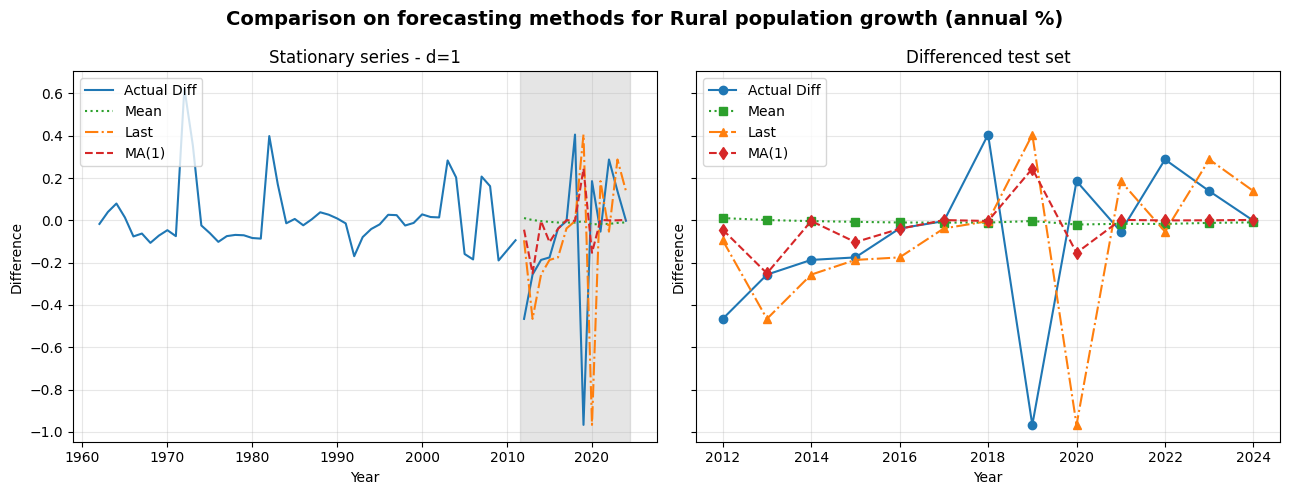


Indicator: Rural population
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie ancora non stazionaria con d=1
Serie resa stazionaria con d=2
Original data - Train: 52, Test: 13
Diff data - Train: 52, 
    Year       Value     Diff
0  1960  20400656.0      NaN
1  1961  20287312.0      NaN
2  1962  20171158.0  -2810.0
3  1963  20063620.0   8616.0
4  1964  19972523.0  16441.0, 
 Test: 13, 
     Year       Value     Diff
52  2012  18849491.0 -88048.0
53  2013  18709265.0 -47647.0
54  2014  18535347.0 -33692.0
55  2015  18330880.0 -30549.0
56  2016  18121734.0  -4679.0


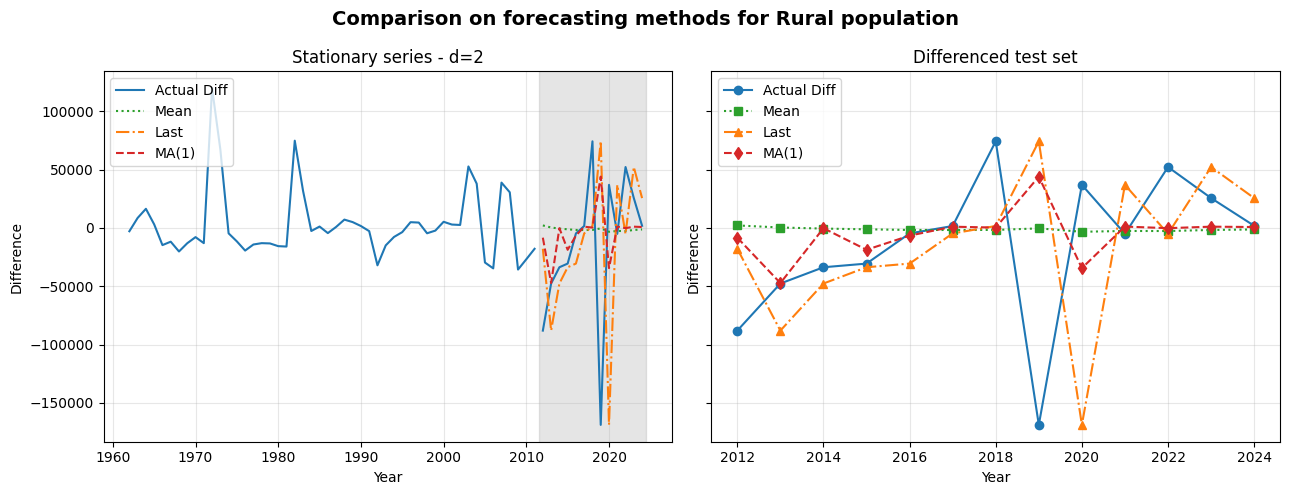


Indicator: Agriculture, forestry, and fishing, value added (% of GDP)
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie ancora non stazionaria con d=1
Serie resa stazionaria con d=2
Original data - Train: 28, Test: 7
Diff data - Train: 28, 
    Year     Value      Diff
0  1990  3.178633       NaN
1  1991  3.235386       NaN
2  1992  3.114250 -0.177889
3  1993  2.995048  0.001933
4  1994  2.988089  0.112244, 
 Test: 7, 
     Year     Value      Diff
28  2018  1.857556 -0.080157
29  2019  1.818669 -0.003011
30  2020  1.928016  0.148235
31  2021  1.833393 -0.203971
32  2022  1.890372  0.151602


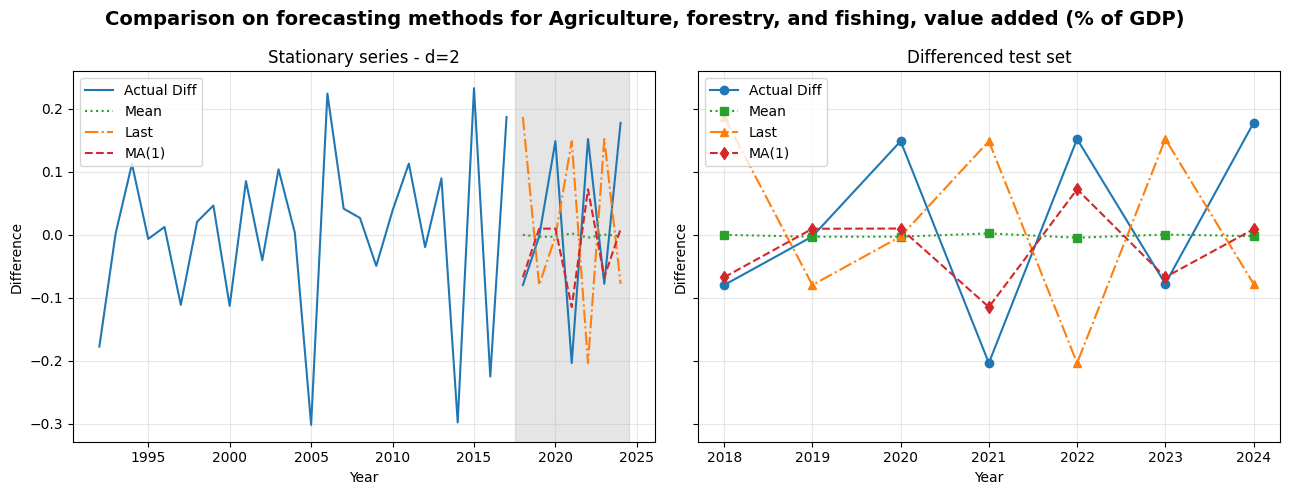


Indicator: Agriculture, forestry, and fishing, value added (current US$)
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie resa stazionaria con d=1
Original data - Train: 28, Test: 7
Diff data - Train: 28, 
    Year         Value          Diff
0  1990  3.763327e+10           NaN
1  1991  4.041296e+10  2.779693e+09
2  1992  4.120790e+10  7.949339e+08
3  1993  3.196952e+10 -9.238378e+09
4  1994  3.292128e+10  9.517599e+08, 
 Test: 7, 
     Year         Value          Diff
28  2018  3.899819e+10  1.683915e+09
29  2019  3.672996e+10 -2.268230e+09
30  2020  3.677654e+10  4.658587e+07
31  2021  3.995344e+10  3.176896e+09
32  2022  3.977470e+10 -1.787407e+08


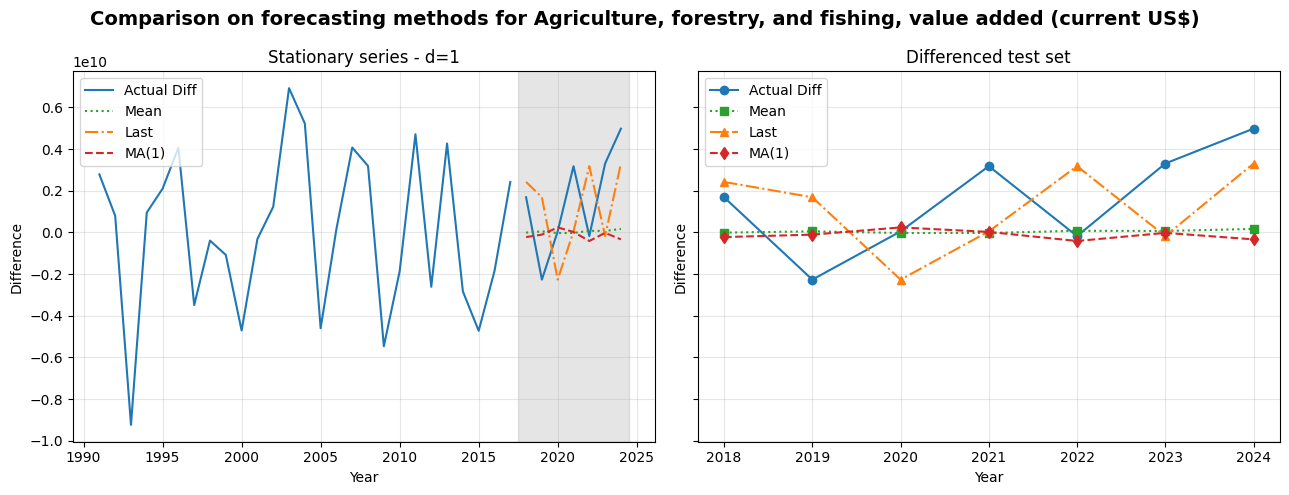


Indicator: Annual freshwater withdrawals, agriculture (% of total freshwater withdrawal)
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie resa stazionaria con d=1
Original data - Train: 41, Test: 11
Diff data - Train: 41, 
    Year      Value      Diff
0  1970  61.538462       NaN
1  1971  60.354920 -1.183542
2  1972  59.201104 -1.153816
3  1973  58.075908 -1.125196
4  1974  56.978280 -1.097628, 
 Test: 11, 
     Year      Value      Diff
41  2011  45.952290  1.867145
42  2012  47.807045  1.854755
43  2013  49.707602  1.900557
44  2014  49.716325  0.008722
45  2015  49.725050  0.008725


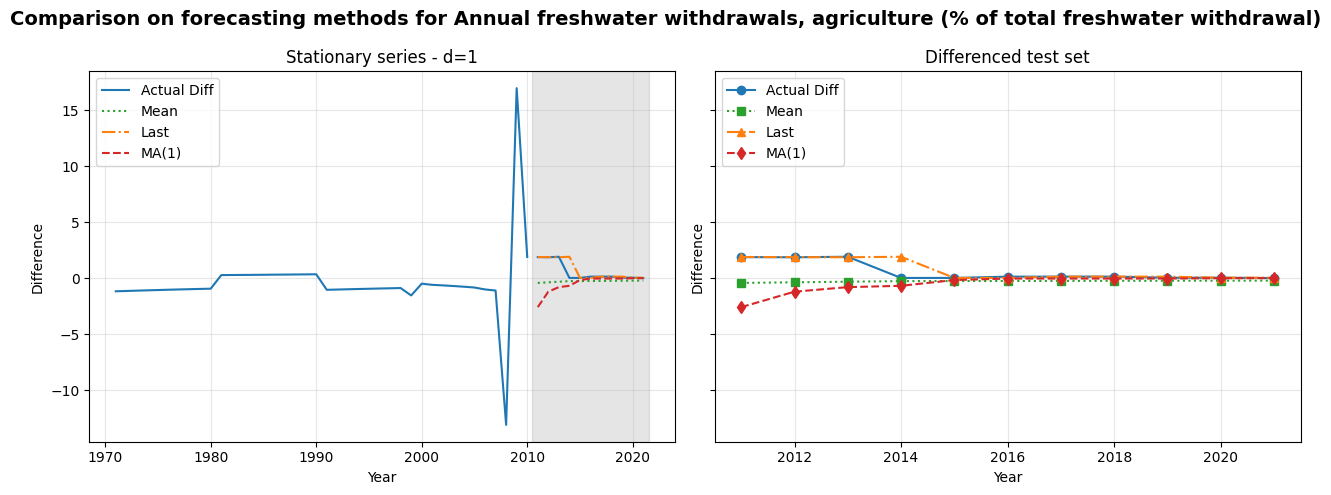


Indicator: Cereal yield (kg per hectare)
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie resa stazionaria con d=1
Original data - Train: 49, Test: 13
Diff data - Train: 49, 
    Year   Value   Diff
0  1961  2181.5    NaN
1  1962  2225.3   43.8
2  1963  2115.2 -110.1
3  1964  2243.0  127.8
4  1965  2399.3  156.3, 
 Test: 13, 
     Year   Value   Diff
49  2010  5322.5  235.6
50  2011  5677.2  354.7
51  2012  5315.1 -362.1
52  2013  5264.6  -50.5
53  2014  5717.5  452.9


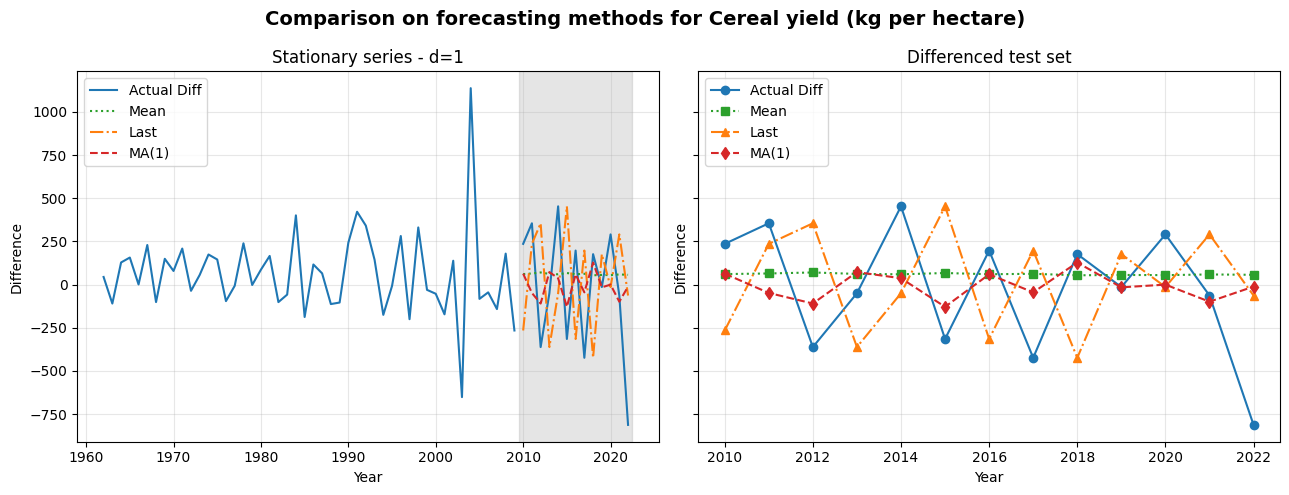


Indicator: Livestock production index (2014-2016 = 100)
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie resa stazionaria con d=1
Original data - Train: 49, Test: 13
Diff data - Train: 49, 
    Year  Value  Diff
0  1961  70.91   NaN
1  1962  72.59  1.68
2  1963  65.95 -6.64
3  1964  69.57  3.62
4  1965  72.80  3.23, 
 Test: 13, 
     Year   Value  Diff
49  2010  109.48 -1.36
50  2011  106.50 -2.98
51  2012  108.77  2.27
52  2013  103.92 -4.85
53  2014   96.02 -7.90


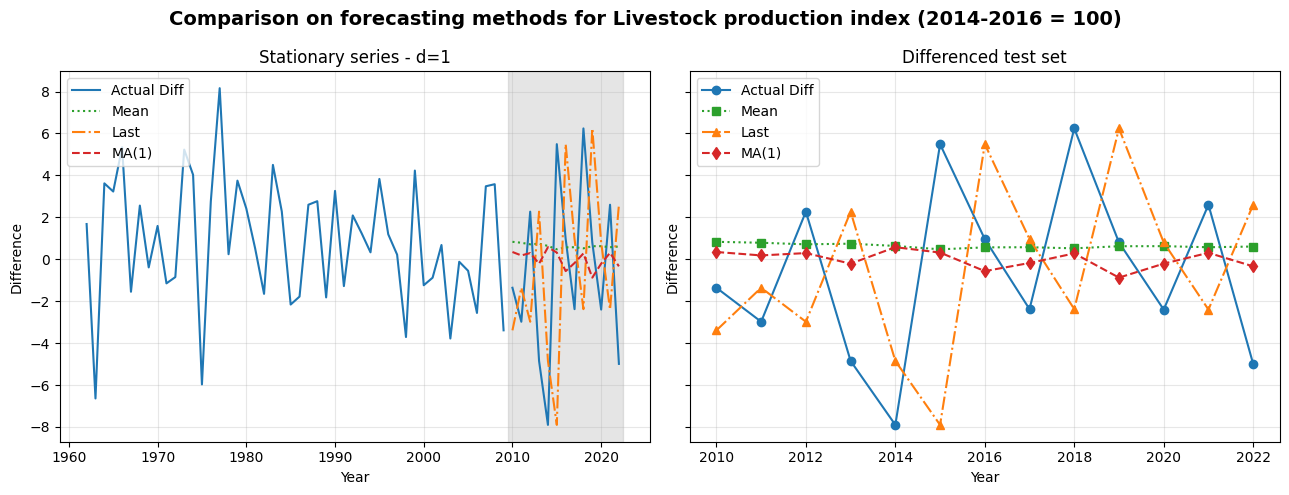


Indicator: Food production index (2014-2016 = 100)
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie resa stazionaria con d=1
Original data - Train: 49, Test: 13
Diff data - Train: 49, 
    Year  Value  Diff
0  1961  85.93   NaN
1  1962  86.90  0.97
2  1963  86.37 -0.53
3  1964  90.28  3.91
4  1965  92.75  2.47, 
 Test: 13, 
     Year   Value  Diff
49  2010  108.51 -3.51
50  2011  107.71 -0.80
51  2012  103.35 -4.36
52  2013  101.77 -1.58
53  2014   95.58 -6.19


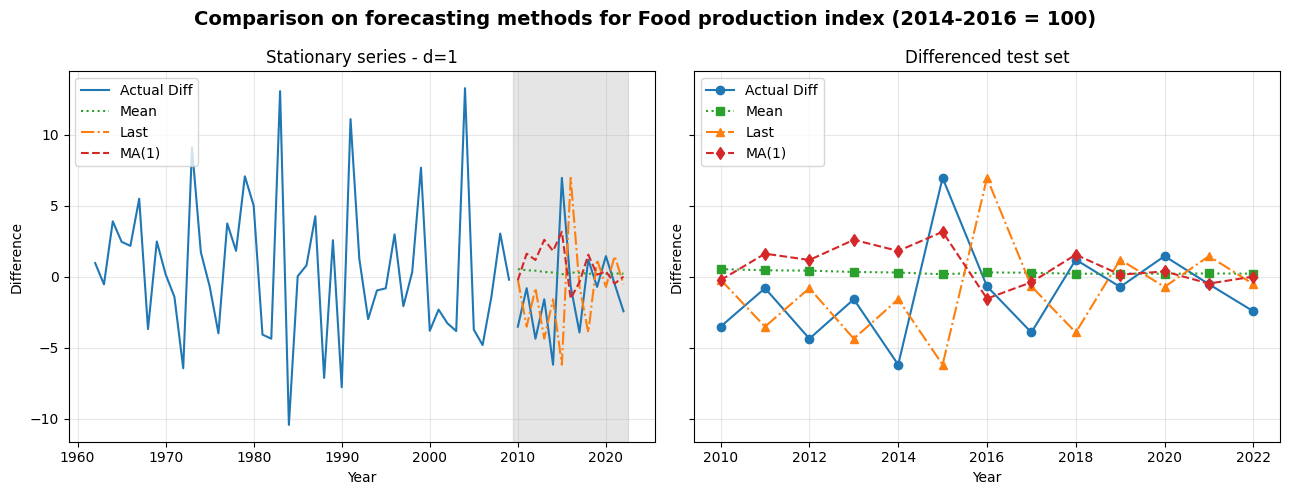


Indicator: Crop production index (2014-2016 = 100)
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie resa stazionaria con d=1
Original data - Train: 49, Test: 13
Diff data - Train: 49, 
    Year   Value  Diff
0  1961   93.68   NaN
1  1962   94.43  0.75
2  1963   97.19  2.76
3  1964  101.31  4.12
4  1965  103.32  2.01, 
 Test: 13, 
     Year   Value  Diff
49  2010  108.31 -4.66
50  2011  108.45  0.14
51  2012  100.58 -7.87
52  2013  100.67  0.09
53  2014   95.40 -5.27


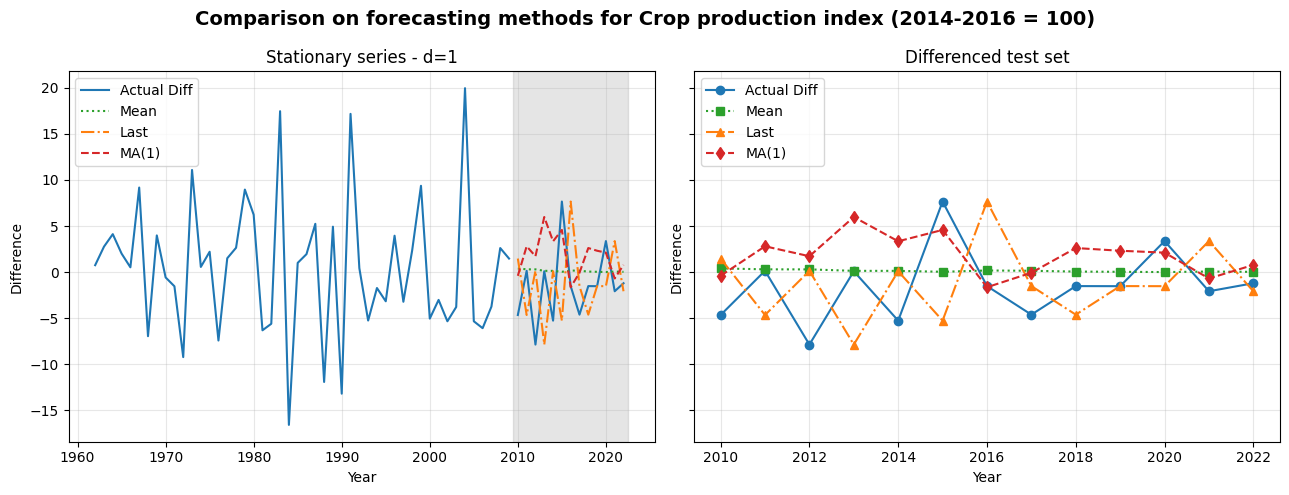


Indicator: Cereal production (metric tons)
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie resa stazionaria con d=1
Original data - Train: 49, Test: 13
Diff data - Train: 49, 
    Year       Value       Diff
0  1961  13933400.0        NaN
1  1962  14433210.0   499810.0
2  1963  13324660.0 -1108550.0
3  1964  14007520.0   682860.0
4  1965  14531270.0   523750.0, 
 Test: 13, 
     Year       Value       Diff
49  2010  18502904.0   797158.0
50  2011  19521138.3  1018234.3
51  2012  18594125.5  -927012.8
52  2013  18214664.0  -379461.5
53  2014  19396843.8  1182179.8


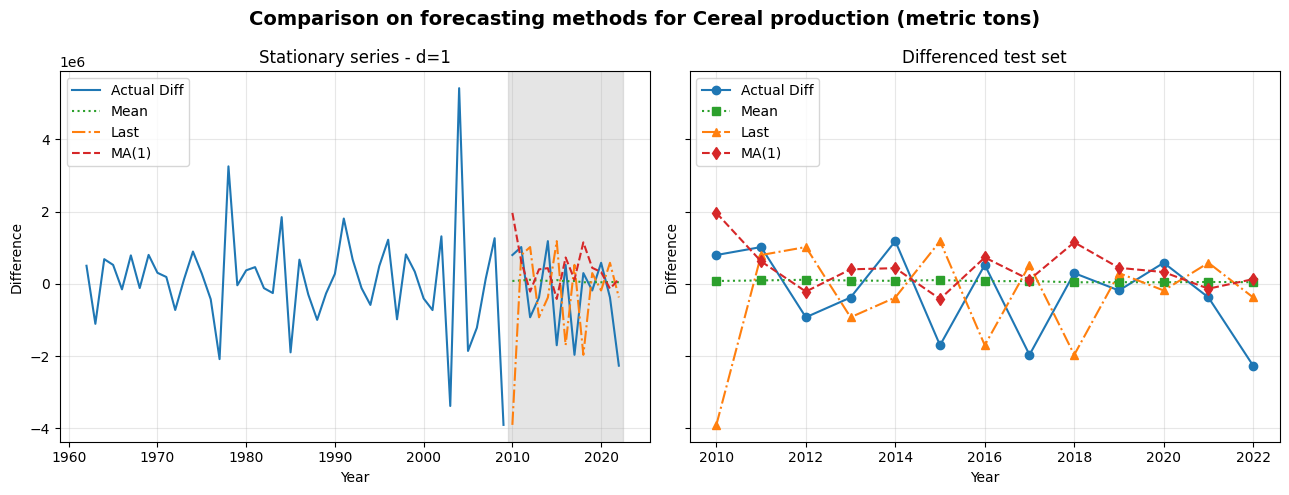


Indicator: Permanent cropland (% of land area)
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie resa stazionaria con d=1
Original data - Train: 49, Test: 13
Diff data - Train: 49, 
    Year     Value      Diff
0  1961  9.336643       NaN
1  1962  9.435245  0.098603
2  1963  9.319642 -0.115603
3  1964  9.438645  0.119003
4  1965  9.445446  0.006800, 
 Test: 13, 
     Year     Value      Diff
49  2010  8.750905  0.031787
50  2011  8.523661 -0.227244
51  2012  8.257867 -0.265794
52  2013  7.642416 -0.615451
53  2014  8.092169  0.449753


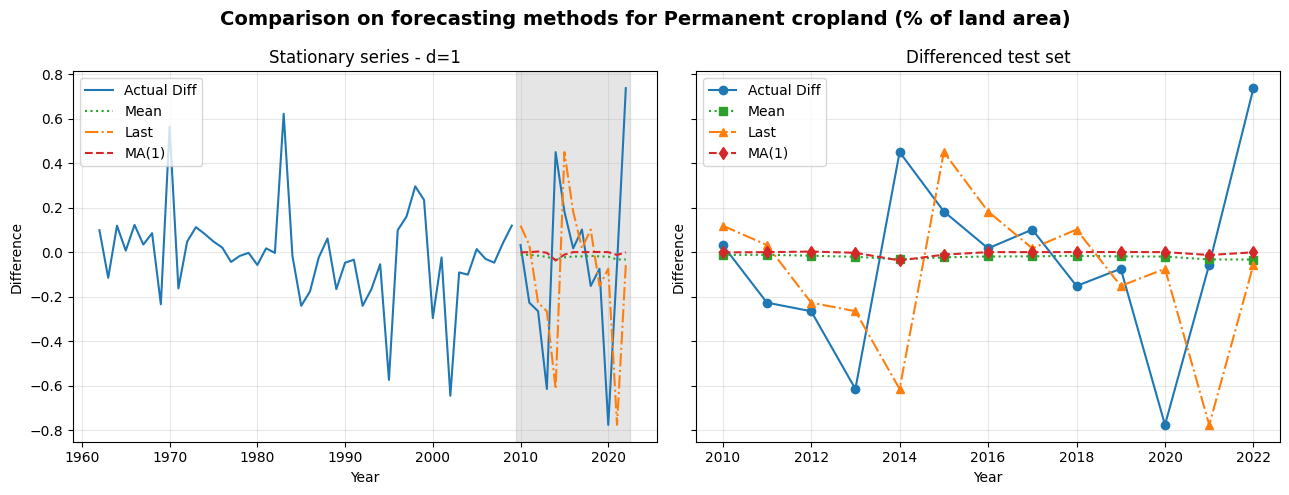


Indicator: Land under cereal production (hectares)
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie resa stazionaria con d=1
Original data - Train: 49, Test: 13
Diff data - Train: 49, 
    Year      Value      Diff
0  1961  6387203.0       NaN
1  1962  6485855.0   98652.0
2  1963  6299467.0 -186388.0
3  1964  6244904.0  -54563.0
4  1965  6056518.0 -188386.0, 
 Test: 13, 
     Year      Value     Diff
49  2010  3476388.0  -4267.0
50  2011  3438491.0 -37897.0
51  2012  3498385.0  59894.0
52  2013  3459869.0 -38516.0
53  2014  3392536.0 -67333.0


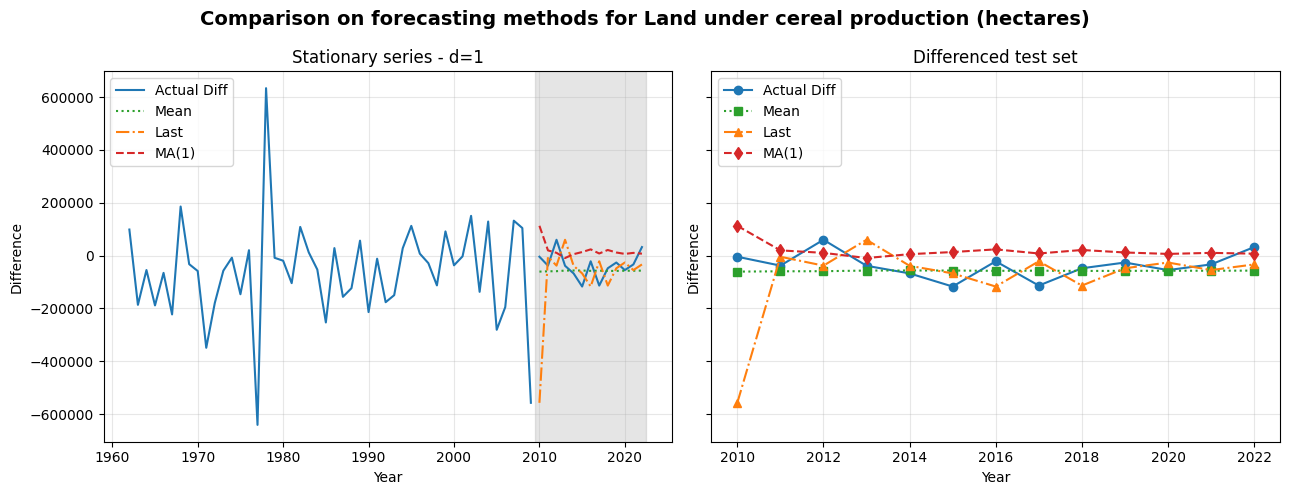


Indicator: Arable land (% of land area)
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie resa stazionaria con d=1
Original data - Train: 49, Test: 13
Diff data - Train: 49, 
    Year      Value      Diff
0  1961  43.731937       NaN
1  1962  43.504131 -0.227806
2  1963  43.092720 -0.411411
3  1964  42.834314 -0.258407
4  1965  42.582707 -0.251607, 
 Test: 13, 
     Year      Value      Diff
49  2010  23.813227  0.206278
50  2011  22.724352 -1.088875
51  2012  24.070229  1.345877
52  2013  23.086183 -0.984046
53  2014  22.751405 -0.334778


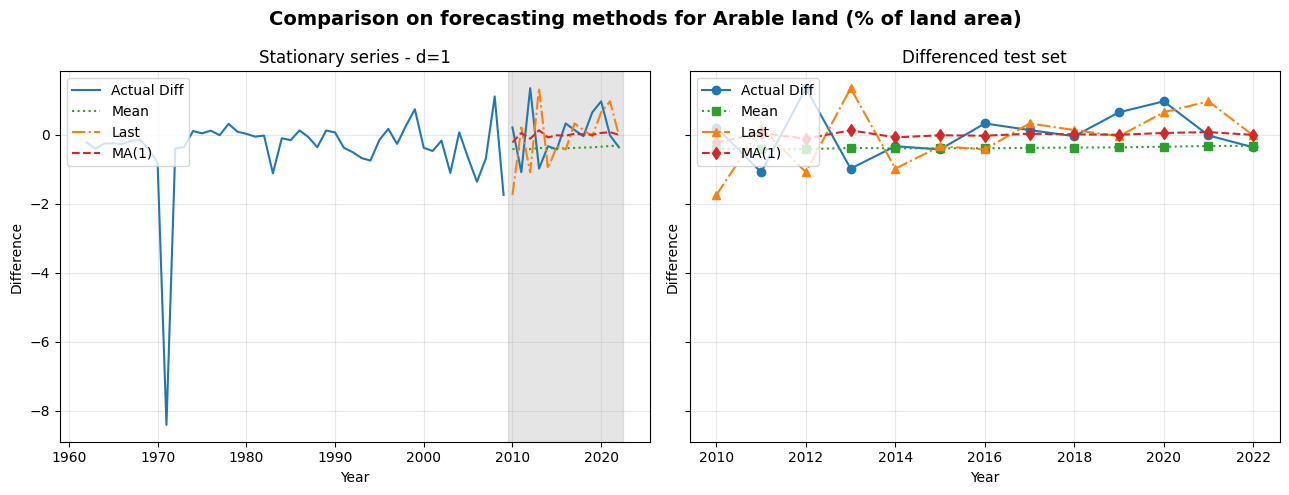


Indicator: Arable land (hectares per person)
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie resa stazionaria con d=1
Original data - Train: 48, Test: 13
Diff data - Train: 48, 
    Year     Value      Diff
0  1961  0.254510       NaN
1  1962  0.251477 -0.003033
2  1963  0.247288 -0.004189
3  1964  0.243791 -0.003497
4  1965  0.240327 -0.003464, 
 Test: 13, 
     Year     Value      Diff
48  2009  0.117218 -0.009413
49  2010  0.117721  0.000503
50  2011  0.111950 -0.005771
51  2012  0.118256  0.006306
52  2013  0.113195 -0.005061


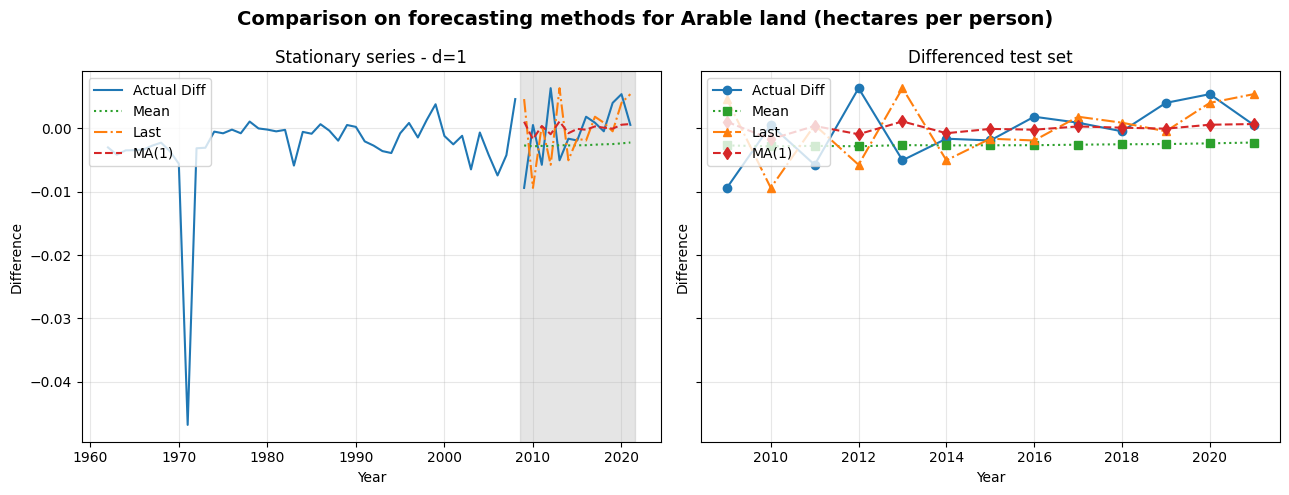


Indicator: Arable land (hectares)
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie resa stazionaria con d=1
Original data - Train: 48, Test: 13
Diff data - Train: 48, 
    Year       Value      Diff
0  1961  12862000.0       NaN
1  1962  12795000.0  -67000.0
2  1963  12674000.0 -121000.0
3  1964  12598000.0  -76000.0
4  1965  12524000.0  -74000.0, 
 Test: 13, 
     Year      Value      Diff
48  2009  6981000.0 -517000.0
49  2010  7042000.0   61000.0
50  2011  6720000.0 -322000.0
51  2012  7118000.0  398000.0
52  2013  6827000.0 -291000.0


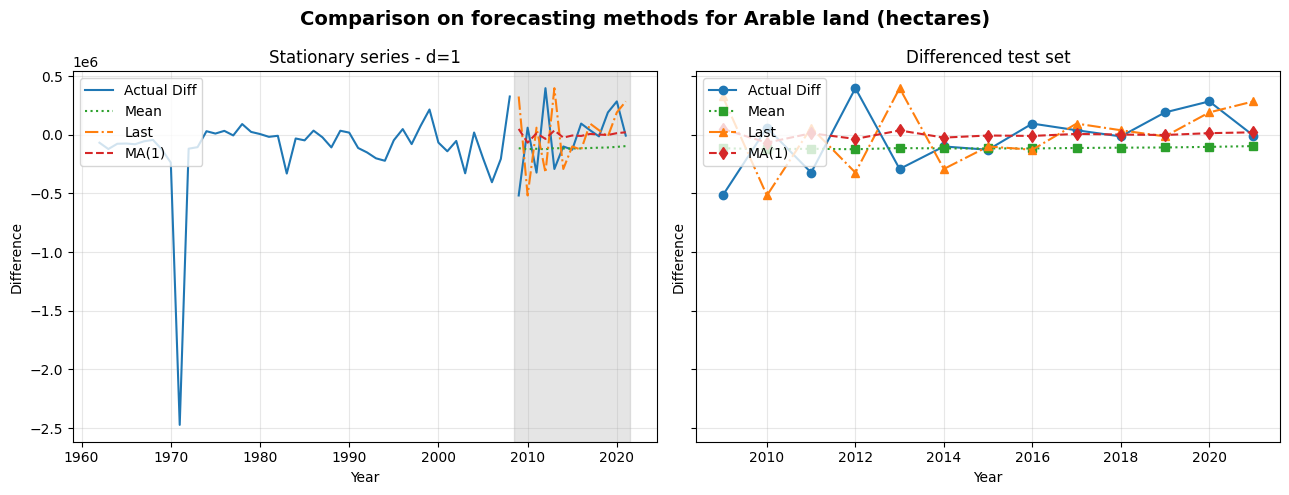


Indicator: Agricultural land (% of land area)
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie resa stazionaria con d=1
Original data - Train: 49, Test: 13
Diff data - Train: 49, 
    Year      Value      Diff
0  1961  70.324028       NaN
1  1962  70.218626 -0.105403
2  1963  69.735813 -0.482813
3  1964  69.572609 -0.163204
4  1965  69.497807 -0.074802, 
 Test: 13, 
     Year      Value      Diff
49  2010  48.450889  1.168005
50  2011  46.843953 -1.606936
51  2012  46.425987 -0.417966
52  2013  46.091209 -0.334778
53  2014  44.508620 -1.582589


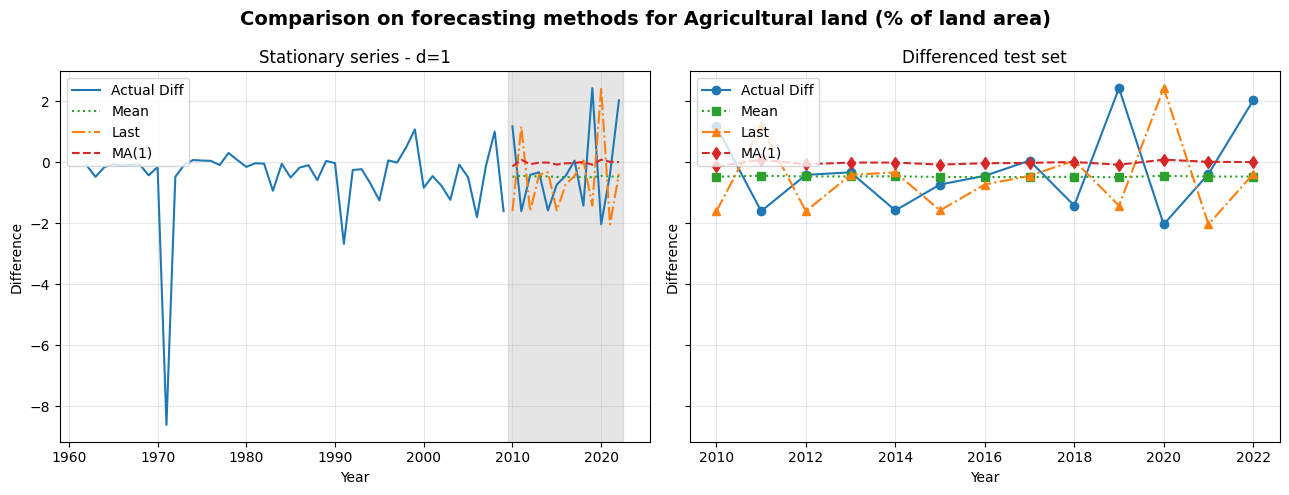


Indicator: Agricultural land (sq. km)
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie resa stazionaria con d=1
Original data - Train: 48, Test: 13
Diff data - Train: 48, 
    Year     Value    Diff
0  1961  206830.0     NaN
1  1962  206520.0  -310.0
2  1963  205100.0 -1420.0
3  1964  204620.0  -480.0
4  1965  204400.0  -220.0, 
 Test: 13, 
     Year     Value    Diff
48  2009  139824.0 -4748.0
49  2010  143278.0  3454.0
50  2011  138526.0 -4752.0
51  2012  137290.0 -1236.0
52  2013  136300.0  -990.0


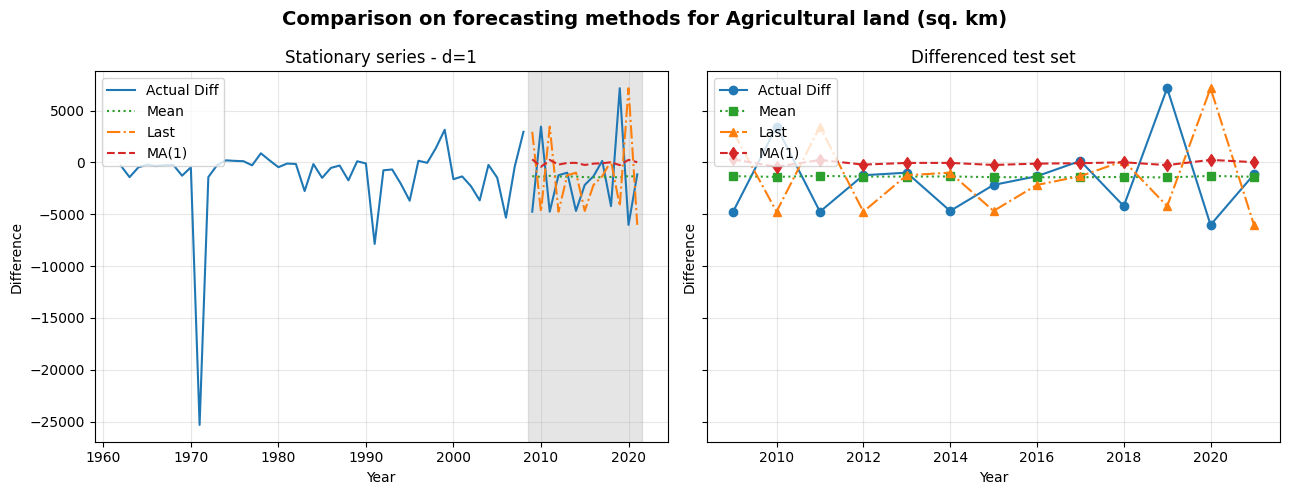


Indicator: Fertilizer consumption (kilograms per hectare of arable land)
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie ancora non stazionaria con d=1
Serie resa stazionaria con d=2
Original data - Train: 49, Test: 13
Diff data - Train: 49, 
    Year      Value      Diff
0  1961  67.795055       NaN
1  1962  69.362485       NaN
2  1963  68.764636 -2.165279
3  1964  74.639625  6.472838
4  1965  86.395481  5.880866, 
 Test: 13, 
     Year       Value       Diff
49  2010  122.745953  25.999036
50  2011  134.322470   8.942153
51  2012  122.506322 -23.392666
52  2013  129.303501  18.613327
53  2014  126.564061  -9.536619


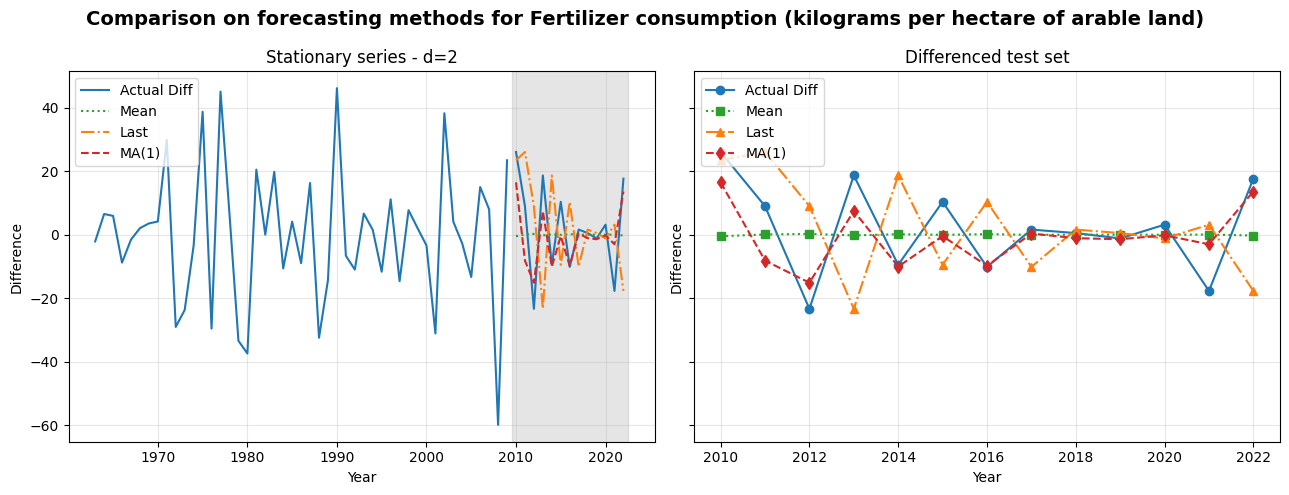


Indicator: Fertilizer consumption (% of fertilizer production)
Serie non stazionaria, quindi differenzio e plotto acf sui valori della time serie differenziati:
Serie resa stazionaria con d=1
Original data - Train: 49, Test: 13
Diff data - Train: 49, 
    Year      Value      Diff
0  1961  72.707716       NaN
1  1962  70.071359 -2.636357
2  1963  63.883735 -6.187623
3  1964  64.593354  0.709619
4  1965  68.034311  3.440957, 
 Test: 13, 
     Year       Value       Diff
49  2010  321.938671  69.597173
50  2011  370.632687  48.694016
51  2012  288.670032 -81.962655
52  2013  193.171051 -95.498981
53  2014  214.141293  20.970242


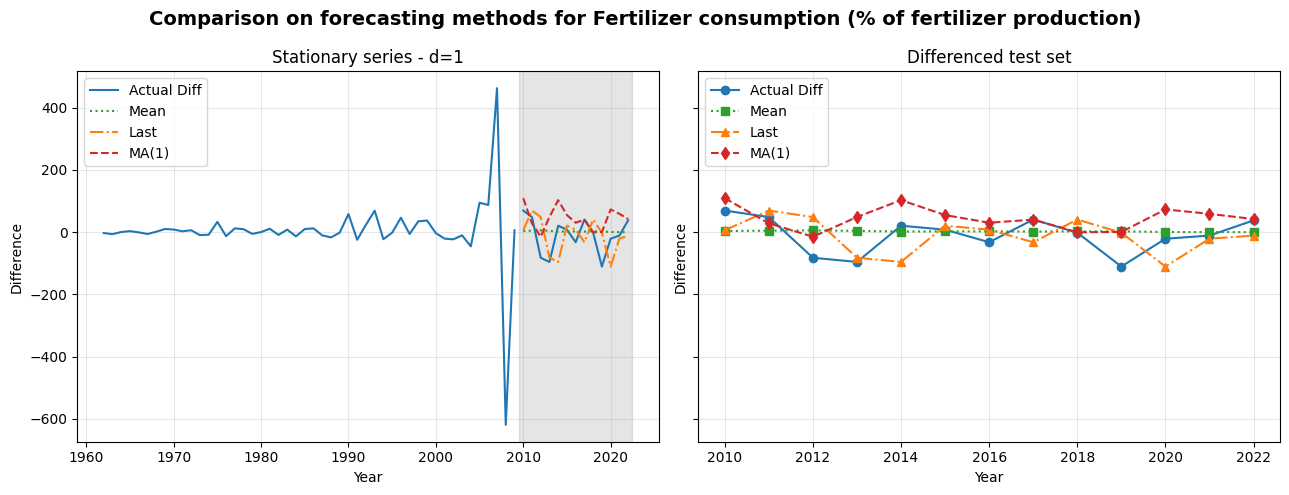

In [30]:
for indicator in SUITABLE:
    print(f"\n{'='*80}")
    print(f"Indicator: {indicator}")

    df_temp = (
        df[df["Indicator Name"] == indicator]
        .melt(id_vars=["Indicator Name"], var_name="Year", value_name="Value")
        .assign(Year=lambda d: d["Year"].astype(int))
        .dropna(subset=["Value"])
        [["Year", "Value"]]
        .reset_index(drop=True)
    )
    
    df_stat, d = make_stationary(df_temp)
    df_temp['Diff'] = df_stat

    split_idx = int(0.8*len(df_temp))
    train = pd.DataFrame(columns=["Year", "Value", "Diff"])
    test = pd.DataFrame(columns=["Year", "Value", "Diff"])
    train = df_temp.iloc[:split_idx]
    test = df_temp.iloc[split_idx:]
    
    TRAIN_LEN = len(train)
    HORIZON = len(test)

    print(f"Original data - Train: {len(train['Value'])}, Test: {len(test['Value'])}")
    print(f"Diff data - Train: {TRAIN_LEN}, \n {train.head()}, \n Test: {HORIZON}, \n {test.head()}")

    pred_mean = rolling_forecast(df_temp, TRAIN_LEN, HORIZON, 1, 'mean')
    pred_last_value = rolling_forecast(df_temp, TRAIN_LEN, HORIZON, 1, 'last')
    pred_MA = rolling_forecast(df_temp, TRAIN_LEN, HORIZON, 1, 'MA')

    test_results = test.copy()
    test_results['pred_mean'] = pred_mean[:HORIZON]
    test_results['pred_last_value'] = pred_last_value[:HORIZON]
    test_results['pred_MA'] = pred_MA[:HORIZON]
    # print(test_results.head())
    
    # PLOT COMPARISON ON FORECASTING METHODS on differenced time series
    plot_comparison_forecasting_methods(indicator, train, test, test_results, d)
    

==================================================================================

KeyError: 'Diff'

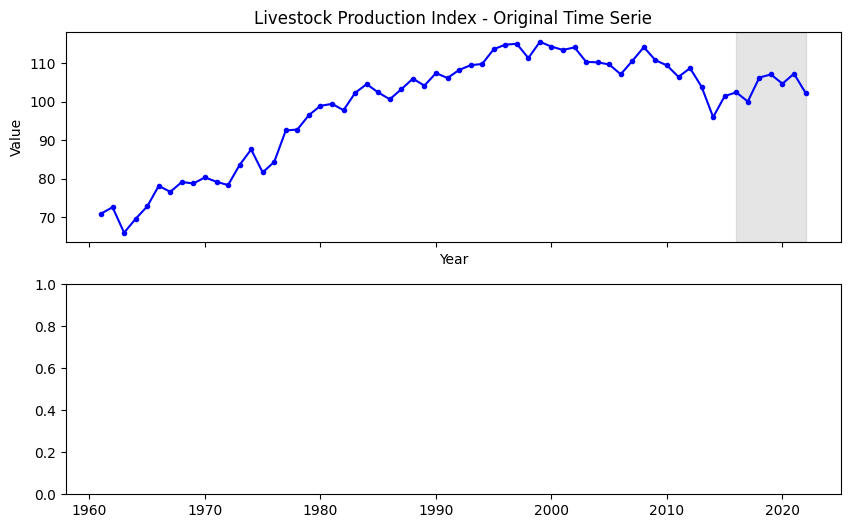

In [ ]:
import matplotlib.pyplot as plt

# PLOT ORIGINAL TIME SERIE VS DIFFERENTIATED TIME SERIE
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 6))

ax1.plot(df_livestock['Year'], df_livestock['Value'], 'b-', marker='.')
ax1.set_xlabel('Year')
ax1.set_ylabel('Value')
ax1.set_title('Livestock Production Index - Original Time Serie')
ax1.axvspan(2016, 2022, color='#808080', alpha=0.2)

ax2.plot(df_livestock['Year'], df_livestock['Diff'], 'r-', marker='.')
ax2.set_xlabel('Year')
ax2.set_ylabel('Value')
ax2.set_title('Livestock Production Index - One-order Differentiated Time Serie')
ax2.axvspan(2016, 2022, color='#808080', alpha=0.2)

ax1.tick_params(labelbottom=True)
ax2.tick_params(labelbottom=True) 
plt.setp(ax2.get_xticklabels(), visible=True) 

plt.tight_layout()
plt.show()

In [ ]:
# DIVISION OF LIVESTOCK PRODUCTION INDEX TIME SERIE IN TRAINING AND TEST SET (90-10)
df_livestock['Diff'] = df_livestock['Diff'].apply(pd.to_numeric, errors='coerce').to_frame()

train = df_livestock[:int(0.9*len(df_livestock))]
test = df_livestock[int(0.9*len(df_livestock)):]

# tot 62:  train 55, test 7
print(len(train))
print(len(test))

55
7


In [ ]:
# ROLLING FORECAST TO MODEL MOVING AVERAGE
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon
    if method == 'mean':
        pred_mean = []
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i])
            pred_mean.extend(mean for _ in range(window))
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))
        return pred_last_value
    
    elif method == 'MA':
        pred_MA = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
        return pred_MA
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(df_livestock['Diff'], TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_livestock['Diff'], TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = rolling_forecast(df_livestock['Diff'], TRAIN_LEN, HORIZON, WINDOW, 'MA')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA

pred_df.head()

Year   Value  Diff  pred_mean  pred_last_value   pred_MA
55  2016  102.47  0.96   0.566667             5.49  0.503091
56  2017  100.09 -2.38   0.573818             0.96 -0.494642
57  2018  106.33  6.24   0.521071            -2.38  0.063690
58  2019  107.13  0.80   0.621404             6.24 -0.219083
59  2020  104.73 -2.40   0.624483             0.80 -0.785769

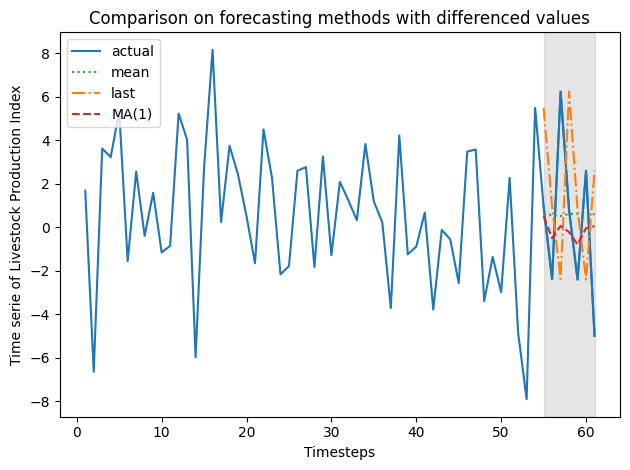

In [ ]:
# PLOT COMPARISON ON FORECASTING METHODS WITH DIFFERENCED VALUES
fig, ax = plt.subplots()
ax.plot(df_livestock['Diff'])
ax.plot(pred_df['Diff'], color = colors[0], linestyle='-', label='actual')
ax.plot(pred_df['pred_mean'], color = colors[1], linestyle=':', label='mean')
ax.plot(pred_df['pred_last_value'], color = colors[2], linestyle='-.', label='last')
ax.plot(pred_df['pred_MA'], color = colors[3], linestyle='--', label='MA(1)')
ax.legend(loc=2)
ax.set_title("Comparison on forecasting methods with differenced values")
ax.set_xlabel('Timesteps')
ax.set_ylabel('Time serie of Livestock Production Index')
ax.axvspan(55, 61, color='#808080', alpha=0.2)

plt.tight_layout()

In [ ]:
# MAE DIFF PREDICTIONS
mae_mean = mean_absolute_error(df_livestock['Diff'].iloc[55:], pred_df['pred_mean'].iloc[0:])
mae_last = mean_absolute_error(df_livestock['Diff'].iloc[55:], pred_df['pred_last_value'].iloc[0:])
mae_MA = mean_absolute_error(df_livestock['Diff'].iloc[55:], pred_df['pred_MA'].iloc[0:])

print(f"MAE DIFF PREDICTIONS = mean: {mae_mean:.2f}, last: {mae_last:.2f}, MA: {mae_MA:.2f}")

MAE DIFF PREDICTIONS = mean: 2.84, last: 5.39, MA: 2.69


In [ ]:
# MSE DIFF PREDICTIONS
mse_mean = mean_squared_error(pred_df['Diff'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['Diff'], pred_df['pred_last_value'])
mse_MA = mean_squared_error(pred_df['Diff'], pred_df['pred_MA'])

print(f"MSE DIFF PREDICTIONS = mean: {mse_mean:.2f}, last: {mse_last:.2f}, MA: {mse_MA:.2f}")

MSE DIFF PREDICTIONS = mean: 12.31, last: 32.63, MA: 11.14


In [ ]:
# # Plot MSE DIFF
# fig, ax = plt.subplots()
# x = ['mean', 'last_value', 'MA(1)']
# y = [mse_mean, mse_last, mse_MA]
# colors = ['green', 'black', 'red']

# ax.bar(x, y, width=0.5, color=colors)
# ax.set_xlabel('Methods')
# ax.set_xlim(-0.5, len(x) - 0.5)
# ax.margins(x=0)
# ax.set_title("Mean Squared Error (MSE) comparison")
# ax.set_ylabel('MSE')
# ax.set_ylim(0, 35)
# for index, value in enumerate(y):
#     plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')
# plt.tight_layout()

In [ ]:
# INVERSE TRANSFORMATION OF DIFFERENCED VALUES

# start_value = df_livestock.loc[54, 'Value']
# df_livestock.loc[55:, 'pred_mean_undiff'] = start_value + pred_df['pred_mean'].cumsum().values

df_livestock['pred_mean_undiff'] = np.nan
df_livestock['pred_last_undiff'] = np.nan
df_livestock['pred_MA_undiff'] = np.nan

start_value = df_livestock.loc[54, 'Value']  # ultimo valore "reale" prima del forecast

pred_mean_undiff = [start_value]
for val in pred_df['pred_mean']:
    pred_mean_undiff.append(pred_mean_undiff[-1] + val)

pred_last_undiff = [start_value]
for val in pred_df['pred_last_value']:
    pred_last_undiff.append(pred_last_undiff[-1] + val)

pred_MA_undiff = [start_value]
for val in pred_df['pred_MA']:
    pred_MA_undiff.append(pred_MA_undiff[-1] + val)

df_livestock.loc[55:55+len(pred_df)-1, 'pred_mean_undiff'] = pred_mean_undiff[1:]
df_livestock.loc[55:55+len(pred_df)-1, 'pred_last_undiff'] = pred_last_undiff[1:]
df_livestock.loc[55:55+len(pred_df)-1, 'pred_MA_undiff'] = pred_MA_undiff[1:]

print(df_livestock.tail())

    Year   Value  Diff  pred_mean_undiff  pred_last_undiff  pred_MA_undiff
57  2018  106.33  6.24        103.171556            105.58      101.582139
58  2019  107.13  0.80        103.792960            111.82      101.363056
59  2020  104.73 -2.40        104.417443            112.62      100.577287
60  2021  107.33  2.60        104.990663            110.22      100.537056
61  2022  102.34 -4.99        105.597663            112.82      100.589697


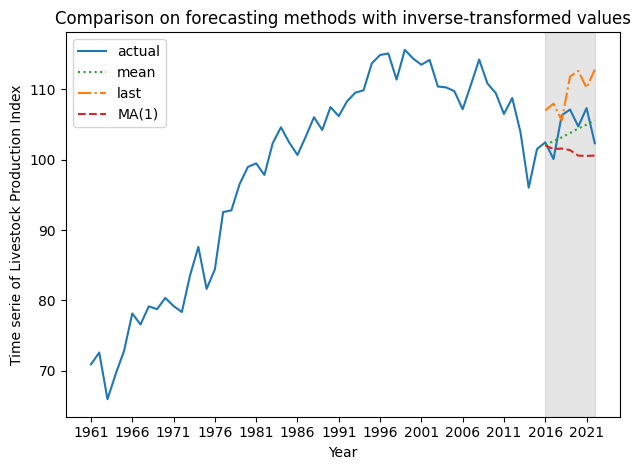

In [ ]:
# Plot comparison on forecasting methods with inverse-trasnformed values
fig, ax = plt.subplots()
ax.plot(df_livestock['Value'], color=colors[0], linestyle='-', label='actual')
ax.plot(df_livestock['pred_mean_undiff'], color=colors[1], linestyle=':', label='mean')
ax.plot(df_livestock['pred_last_undiff'], color=colors[2], linestyle='-.', label='last')
ax.plot(df_livestock['pred_MA_undiff'], color=colors[3], linestyle='--', label='MA(1)')
ax.legend(loc=2)
ax.set_title("Comparison on forecasting methods with inverse-transformed values")
ax.set_xlabel('Year')
ax.set_ylabel('Time serie of Livestock Production Index')
ax.set_xticks(range(0, len(df_livestock), 5)) 
ax.set_xticklabels(df_livestock['Year'][::5])
ax.axvspan(55, 61, color='#808080', alpha=0.2)
plt.tight_layout()

In [ ]:
# MAE UNDIFF PREDICTIONS
mae_mean_undiff = mean_absolute_error(df_livestock['Value'].iloc[55:], df_livestock['pred_mean_undiff'].iloc[55:])
mae_last_undiff = mean_absolute_error(df_livestock['Value'].iloc[55:], df_livestock['pred_last_undiff'].iloc[55:])
mae_MA_undiff = mean_absolute_error(df_livestock['Value'].iloc[55:], df_livestock['pred_MA_undiff'].iloc[55:])

print(f"MAE UNDIFF PREDICTIONS = mean: {mae_mean_undiff:.2f}, last: {mae_last_undiff:.2f}, MA: {mae_MA_undiff:.2f}")

MAE UNDIFF PREDICTIONS = mean: 2.19, last: 5.59, MA: 3.59


In [ ]:
# MSE UNDIFF PREDICTION
mse_mean_undiff = mean_squared_error(df_livestock['Value'].iloc[55:], df_livestock['pred_mean_undiff'].iloc[55:])
mse_last_undiff = mean_squared_error(df_livestock['Value'].iloc[55:], df_livestock['pred_last_undiff'].iloc[55:])
mse_MA_undiff = mean_squared_error(df_livestock['Value'].iloc[55:], df_livestock['pred_MA_undiff'].iloc[55:])

print(f"MSE UNDIFF PREDICTION = mean: {mse_mean_undiff:.2f}, last: {mse_last_undiff:.2f}, MA: {mse_MA_undiff:.2f}")

MSE UNDIFF PREDICTION = mean: 6.29, last: 40.78, MA: 17.79


In [ ]:
# # Plot MAE UNDIFF
# fig, ax = plt.subplots()
# x = ['mean', 'last_value', 'MA(1)']
# y = [mae_mean_undiff, mae_last_undiff, mae_MA_undiff]
# colors = ['green', 'black', 'red']

# ax.bar(x, y, width=0.5, color=colors)
# ax.set_xlabel('Methods')
# ax.set_xlim(-0.5, len(x) - 0.5)
# ax.margins(x=0)
# ax.set_title("Mean Absolute Error (MAE) comparison")
# ax.set_ylabel('MAE')
# ax.set_ylim(0, 35)
# for index, value in enumerate(y):
#     plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')
# plt.tight_layout()

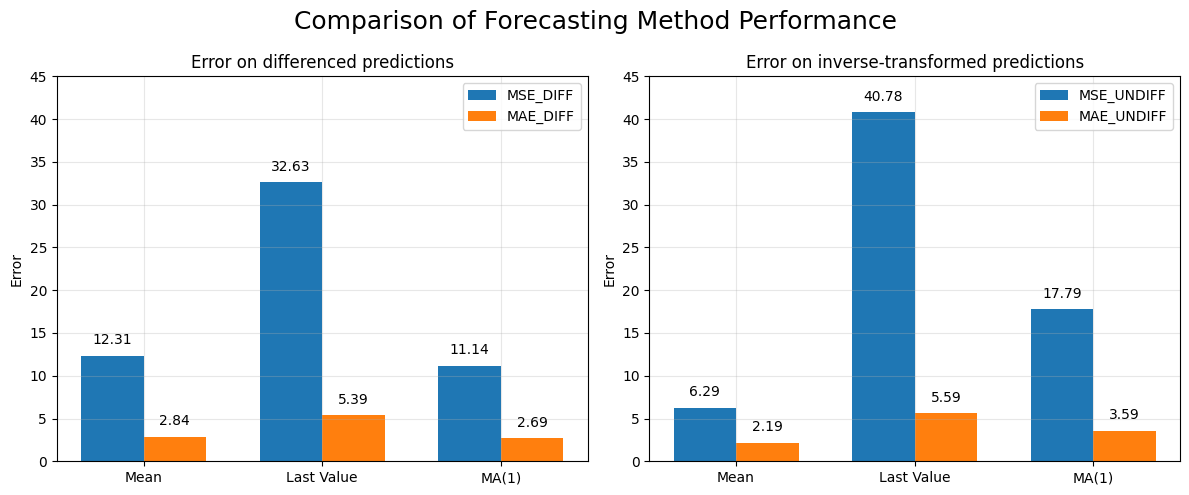

In [ ]:
results = pd.DataFrame({
    'Method': ['Mean', 'Last Value', 'MA(1)'],
    'MSE_DIFF': [mse_mean, mse_last, mse_MA],
    'MAE_DIFF': [mae_mean, mae_last, mae_MA],
    'MSE_UNDIFF': [mse_mean_undiff, mse_last_undiff, mse_MA_undiff],
    'MAE_UNDIFF': [mae_mean_undiff, mae_last_undiff, mae_MA_undiff]
})

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

x = np.arange(len(results['Method']))
width = 0.35

# GRAFICO MSE_DIFF E MAE_DIFF
axes[0].bar(x - width/2, results['MSE_DIFF'], width, label='MSE_DIFF')
axes[0].bar(x + width/2, results['MAE_DIFF'], width, label='MAE_DIFF')
axes[0].set_xticks(x)
axes[0].set_xticklabels(results['Method'])
axes[0].set_title("Error on differenced predictions")
axes[0].set_ylabel("Error")
axes[0].set_ylim(0, 45)
axes[0].legend()
axes[0].grid(alpha=0.3)

for idx in x:
    axes[0].text(idx - width/2, results['MSE_DIFF'][idx] + 1, f"{results['MSE_DIFF'][idx]:.2f}", ha='center', va='bottom')
    axes[0].text(idx + width/2, results['MAE_DIFF'][idx] + 1, f"{results['MAE_DIFF'][idx]:.2f}", ha='center', va='bottom')

# GRAFICO MSE_UNDIFF E MAE_UNDIFF
axes[1].bar(x - width/2, results['MSE_UNDIFF'], width, label='MSE_UNDIFF')
axes[1].bar(x + width/2, results['MAE_UNDIFF'], width, label='MAE_UNDIFF')
axes[1].set_xticks(x)
axes[1].set_xticklabels(results['Method'])
axes[1].set_title("Error on inverse-transformed predictions")
axes[1].set_ylabel("Error")
axes[1].set_ylim(0, 45)
axes[1].legend()
axes[1].grid(alpha=0.3)

for idx in x:
    axes[1].text(idx - width/2, results['MSE_UNDIFF'][idx] + 1, f"{results['MSE_UNDIFF'][idx]:.2f}", ha='center', va='bottom')
    axes[1].text(idx + width/2, results['MAE_UNDIFF'][idx] + 1, f"{results['MAE_UNDIFF'][idx]:.2f}", ha='center', va='bottom')

plt.suptitle("Comparison of Forecasting Method Performance", fontsize=18)
plt.tight_layout()
plt.show()